### Problem Statement:
Surprise housing is a US based housing company. The company's model is to purchase the houses below their actual price and sell them at hiher price. The company is entering in Australian market and wants to study the market. The company has collected the data of sale of houses in Australia. 
### Requirement: 
The company want t build a reression model usin regularization to predict the actual value of prospective properties to decide whether to invest or not. Secondly they also want to know which variables are sinificant to predict the price and how well these variables describe the price of the house. As analyst we are require to determine the optimal value of lambda.
### Approach: 
- Step 1: Understanding the date, Data Preperation & EDA
- Step 2: Model building and evaluation with both ridge and lasso regression methods. Finding optimal alpha. Evaluating changes in the predictor variables due to the change in alpha. Explaining the rationale for choosing the model
- Step 3: Rebuild the model without top 5 predictor variables as asked in the assignment
- Step 4: Explaning the rationale for making the model robust and generalized

In [1]:
# importing the requisite libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')# import all libraries

In [2]:
# Reading the dataset
housing = pd.read_csv(r'C:\Users\Amarjit\Downloads\train.csv')

In [3]:
housing.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Data Understanding, Preparation and EDA
1. Identify and treat missing values. Remove duplicate
2. Treat dummy variables
3. remove redundant data
4. perform scaling

### Missing value treatment:
- Id - Let's drop as it is redundant
- LotFrontage - There are 259 properties where the information about the street connected to prperty is not available. Lets replace the missing value with median value i.e. 69
- MasVnrType & MasVnrArea - There are 7 properties where mesonry veneer type is not given. Let's replace it with None
- Electrical - There is one property where the information is not available. Lets consider it as Mixed.

In [4]:
# Lets drop the redundant clumn Id
housing.drop(columns=['Id'], inplace=True)

In [5]:
# Let's inpute the missing values in LotFrontage with median value
housing['LotFrontage'].fillna(69, inplace=True)

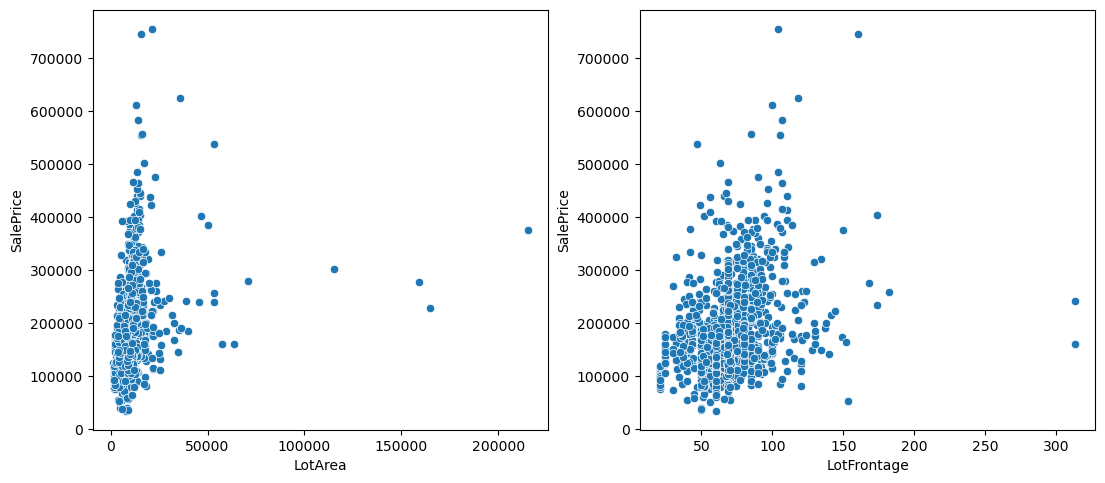

In [6]:
# Plotting a scatter plot to check if the lot frontage and lot size has any relationship too the target variable 
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.scatterplot( data = housing , x = 'LotArea' , y = 'SalePrice')
plt.subplot(2,3,2)
sns.scatterplot( data = housing , x = 'LotFrontage' , y = 'SalePrice')
plt.show()

In [7]:
# The graph shows that Lot frontage has better relationship than lot Area and hence we can drop lot area
housing.drop(columns=['LotArea'], inplace=True)

In [9]:
# Let's inpute the missing values in Alley as the missing value denotes No Alley access
housing['Alley'].fillna('NoAccess', inplace=True)

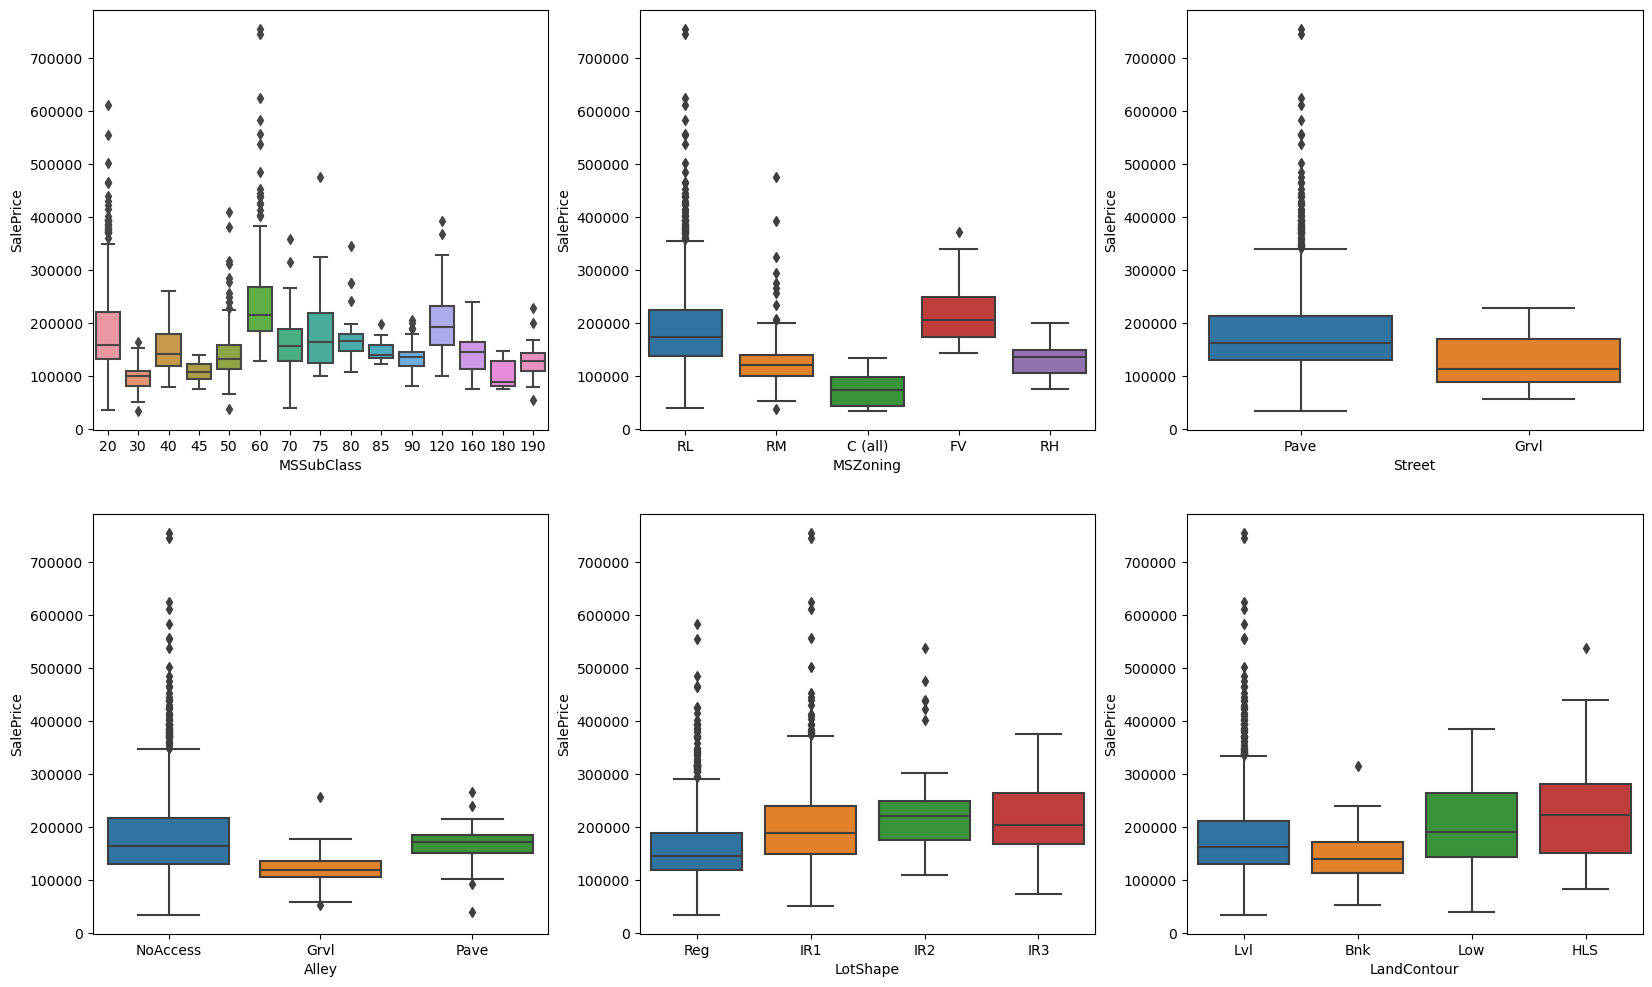

In [10]:
#Let's check the relatinship between the categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'Street', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'Alley', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'LotShape', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'LandContour', y = 'SalePrice', data = housing)
plt.show()

In [11]:
# We can see that all features have stronger relationship with target variable than LotShape and LandContour. So let's drop them
housing.drop(columns=['LotShape'], inplace=True)
housing.drop(columns=['LandContour'], inplace=True)

In [61]:
# We can see Alley has alot of missing values and hence can be dropped
housing.drop(columns=['Alley'], inplace=True)

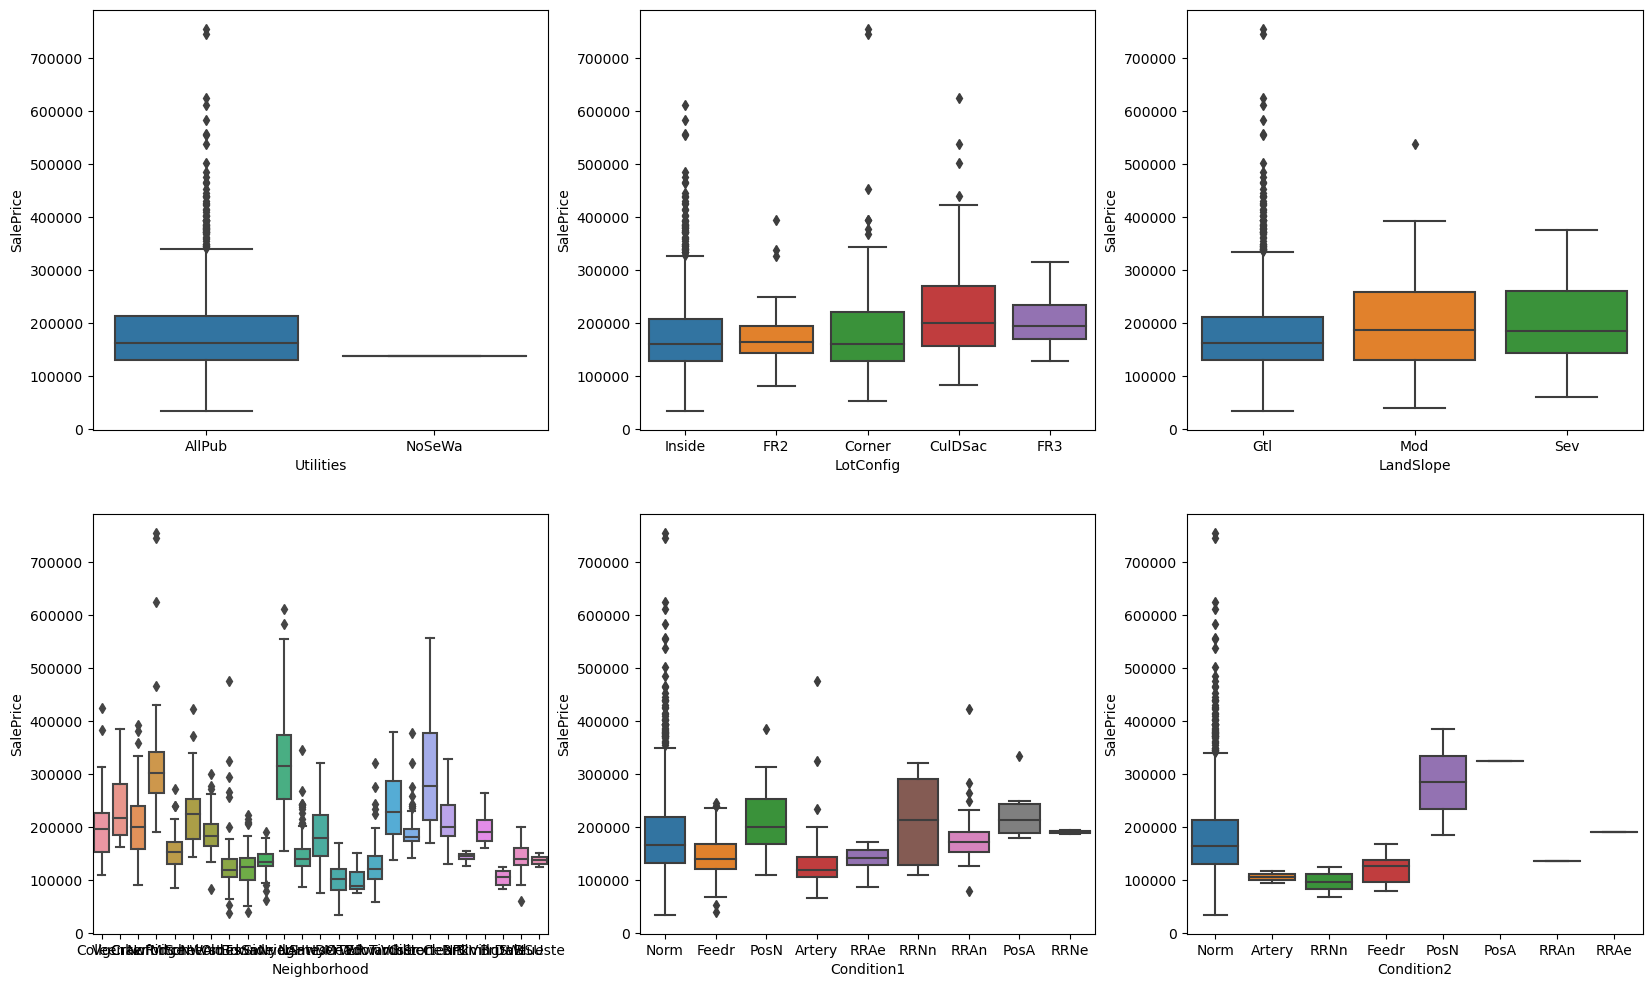

In [12]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'Utilities', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'LotConfig', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'LandSlope', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'Condition1', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'Condition2', y = 'SalePrice', data = housing)
plt.show()

In [13]:
# We can see that all features have stronger relationship with target variable than LotConfig and LandSlope. So let's drop them
housing.drop(columns=['LotConfig'], inplace=True)
housing.drop(columns=['LandSlope'], inplace=True)

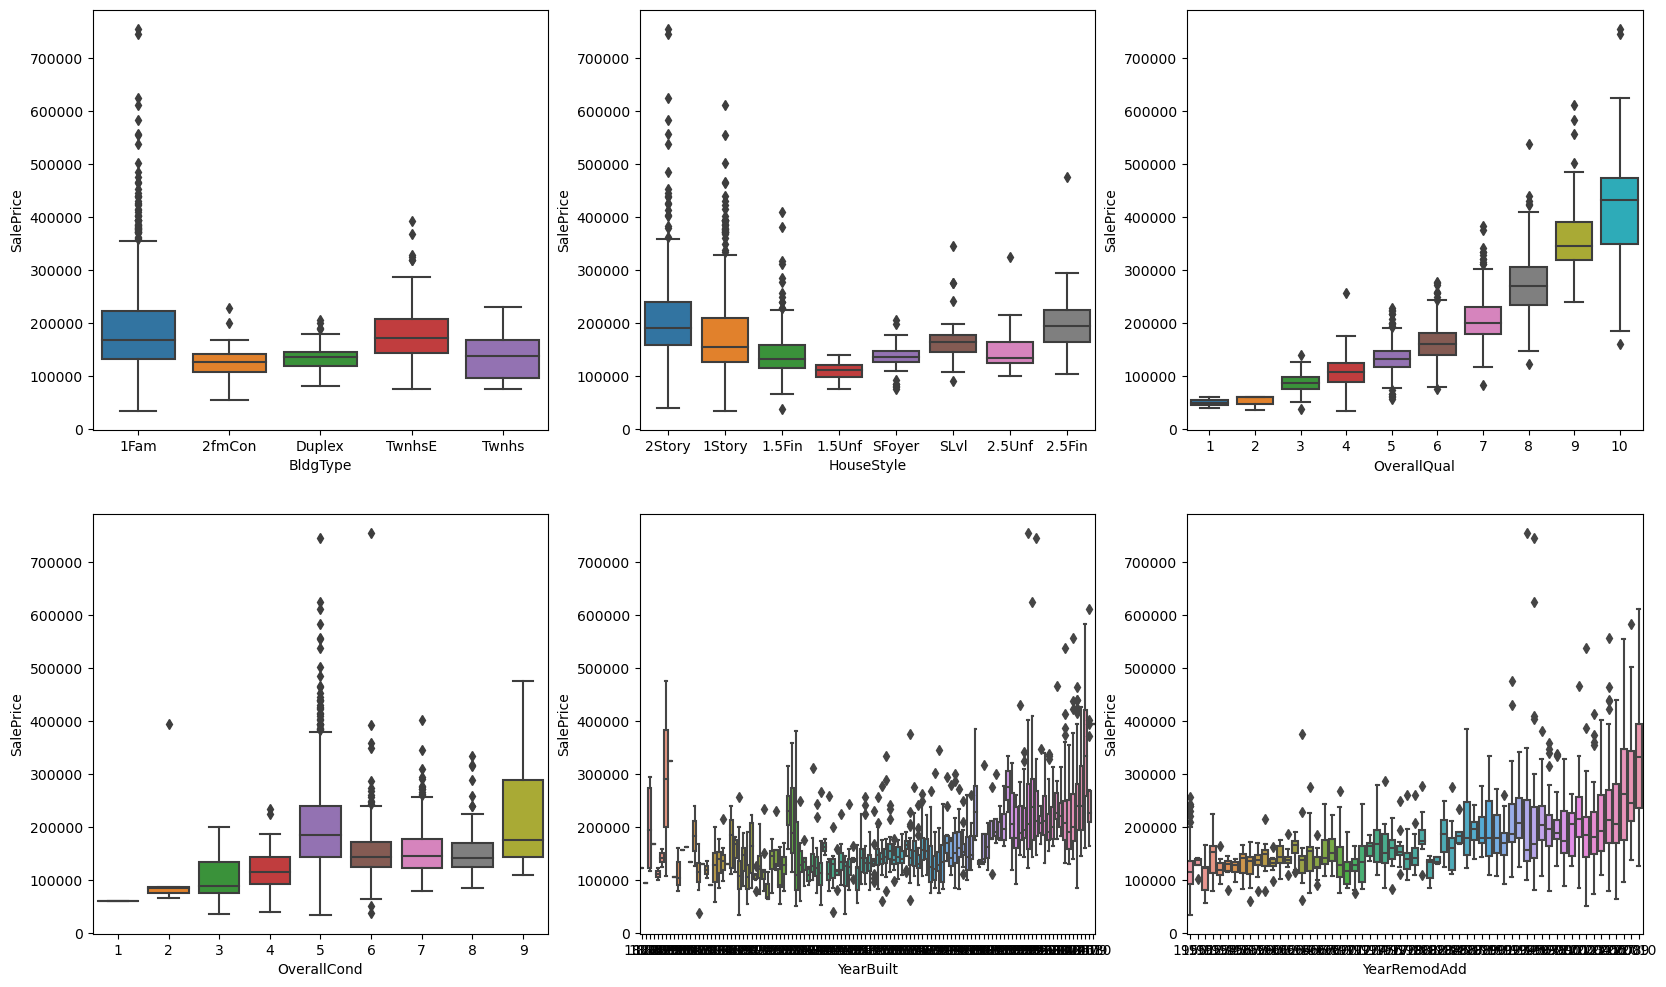

In [14]:

#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'YearRemodAdd', y = 'SalePrice', data = housing)
plt.show()

In [15]:
# All these features show strong relationship and hence let's keep them for model buiding
# Let's input MasVnrType as NA means the the roperty does not have Masonry veneer work and MasVnrArea witth 0
housing['MasVnrType'].fillna('None', inplace=True)
housing['MasVnrArea'].fillna(0, inplace=True)

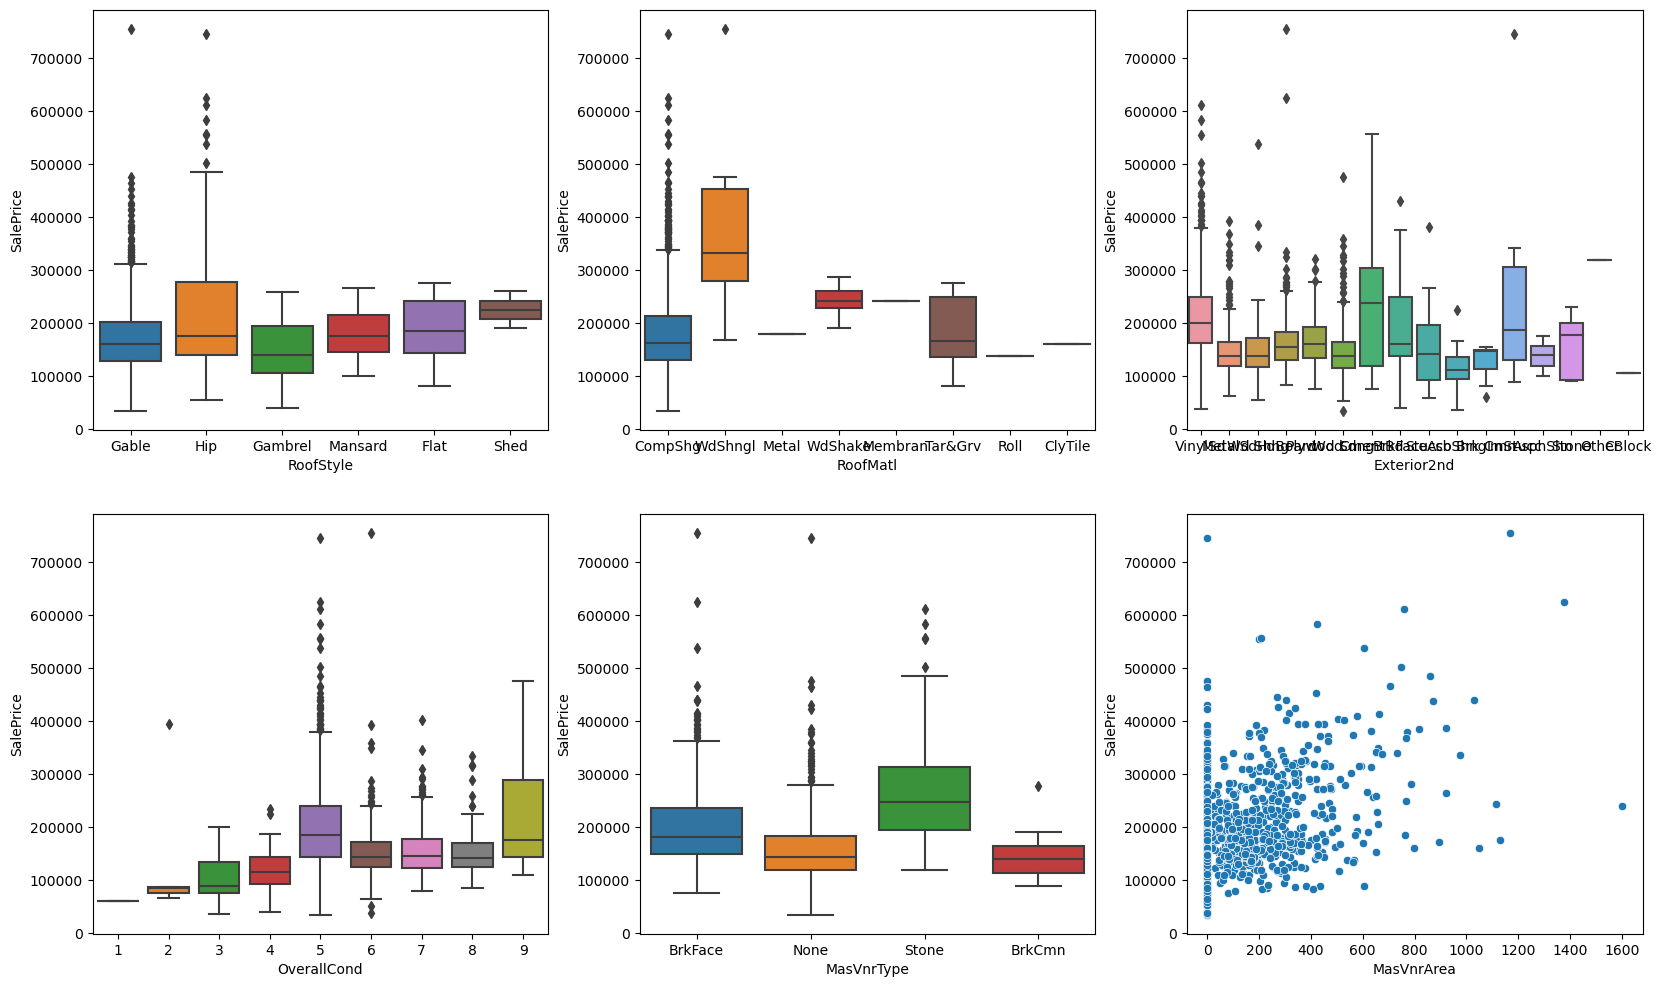

In [19]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'RoofMatl', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'Exterior2nd', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.scatterplot(data = housing , x = 'MasVnrArea', y = 'SalePrice')
plt.show()

In [20]:
# We can see that all features have stronger relationship with target variable than RoofStyle and MasVnrArea. So let's drop them
housing.drop(columns=['RoofStyle'], inplace=True)
housing.drop(columns=['MasVnrArea'], inplace=True)

In [21]:
# Let's inpute the missing values in BsmtQual, BsmtCond & BsmtExposure as the missing value denotes No basement
housing['BsmtQual'].fillna('No_Bsmt', inplace=True)
housing['BsmtCond'].fillna('No_Bsmt', inplace=True)
housing['BsmtExposure'].fillna('No_Bsmt', inplace=True)

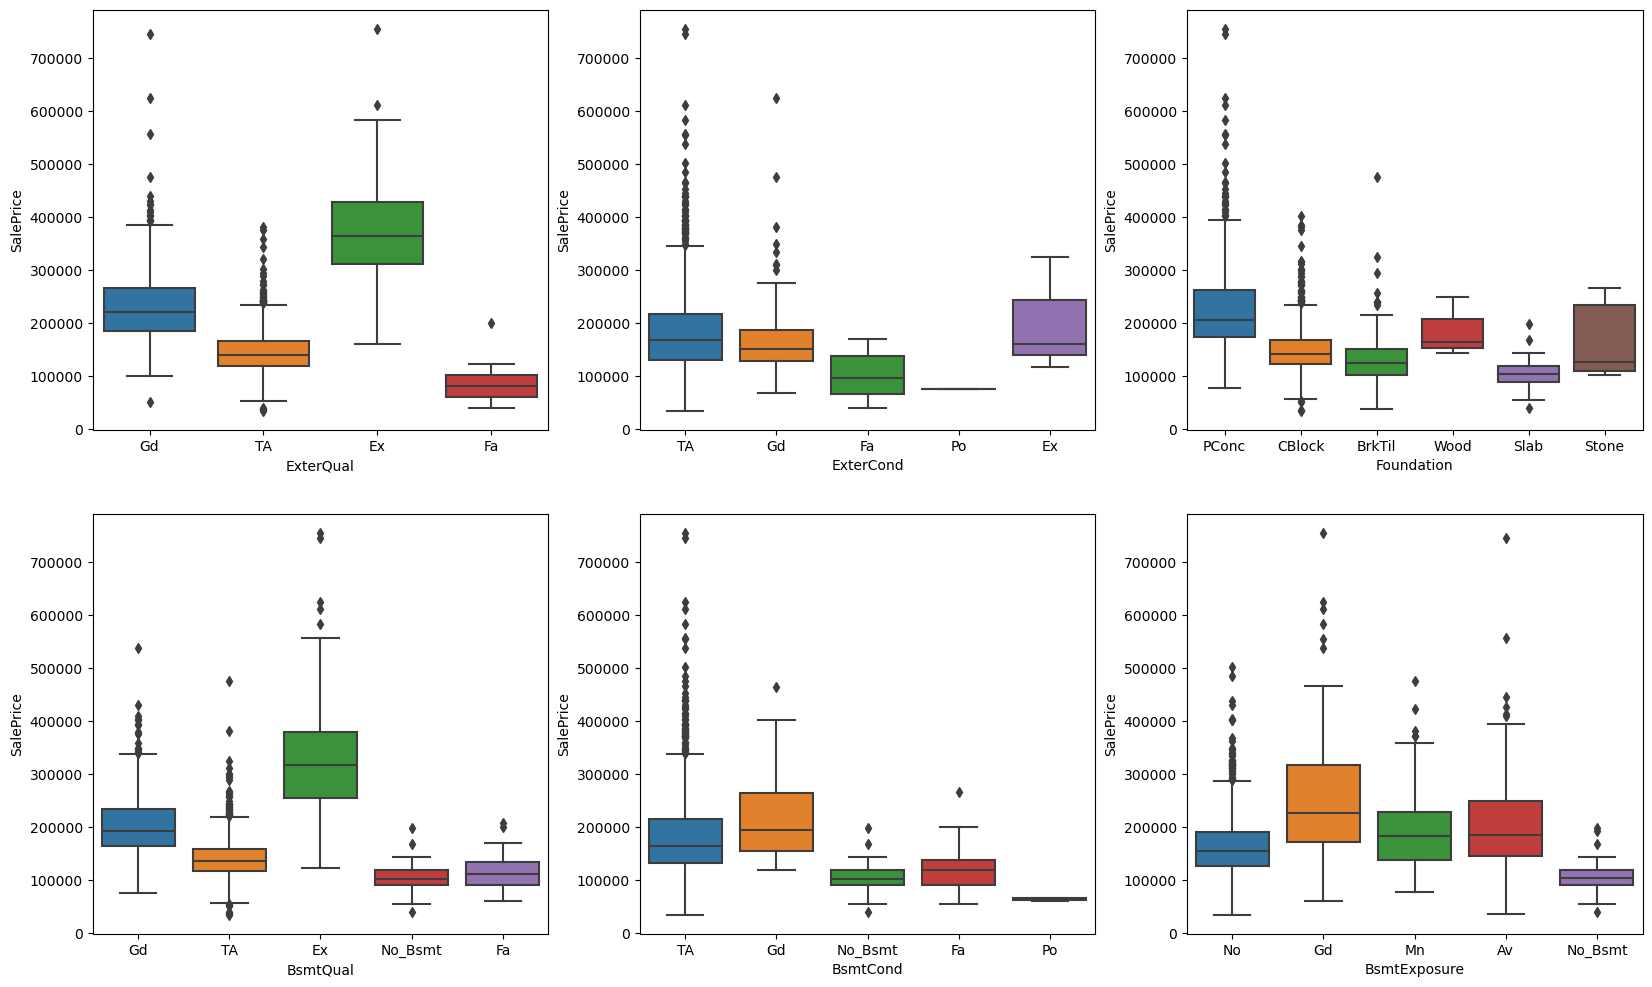

In [22]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'ExterQual', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'ExterCond', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'Foundation', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'BsmtQual', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'BsmtCond', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'BsmtExposure', y = 'SalePrice', data = housing)
plt.show()

In [25]:
# All these features show strong relationship and hence let's keep them for model buiding
# Features ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure are ordinal variables and hence they can be converted to numerical variables
# Define mapping dictionary
ExterQual_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['ExterQual'] = housing['ExterQual'].map(ExterQual_mapping).astype(int)

In [26]:
# Define mapping dictionary
ExterCond_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['ExterCond'] = housing['ExterCond'].map(ExterCond_mapping).astype(int)

In [27]:
# Define mapping dictionary
BsmtQual_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'No_Bsmt': 0}
# Apply mapping to the column
housing['BsmtQual'] = housing['BsmtQual'].map(BsmtQual_mapping).astype(int)

In [24]:
# Define mapping dictionary
bsmtcond_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'No_Bsmt': 0}
# Apply mapping to the column
housing['BsmtCond'] = housing['BsmtCond'].map(bsmtcond_mapping).astype(int)


In [28]:
# Define mapping dictionary
BsmtExposure_mapping = {'Gd': 1, 'Av': 2, 'Mn': 3, 'No': 4, 'No_Bsmt': 5}
# Apply mapping to the column
housing['BsmtExposure'] = housing['BsmtExposure'].map(BsmtExposure_mapping).astype(int)

In [30]:
# Features BsmtFinType1, BsmtFinType2 are ordinal variables and hence they can be converted to numerical variables
# Define mapping dictionary
BsmtFinType1_mapping = {'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'Unf': 6}

# Apply mapping to the column
housing['BsmtFinType1'] = housing['BsmtFinType1'].map(BsmtFinType1_mapping).fillna(0).astype(int)


In [31]:
# Define mapping dictionary
BsmtFinType2_mapping = {'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'Unf': 6}

# Apply mapping to the column
housing['BsmtFinType2'] = housing['BsmtFinType2'].map(BsmtFinType2_mapping).fillna(0).astype(int)

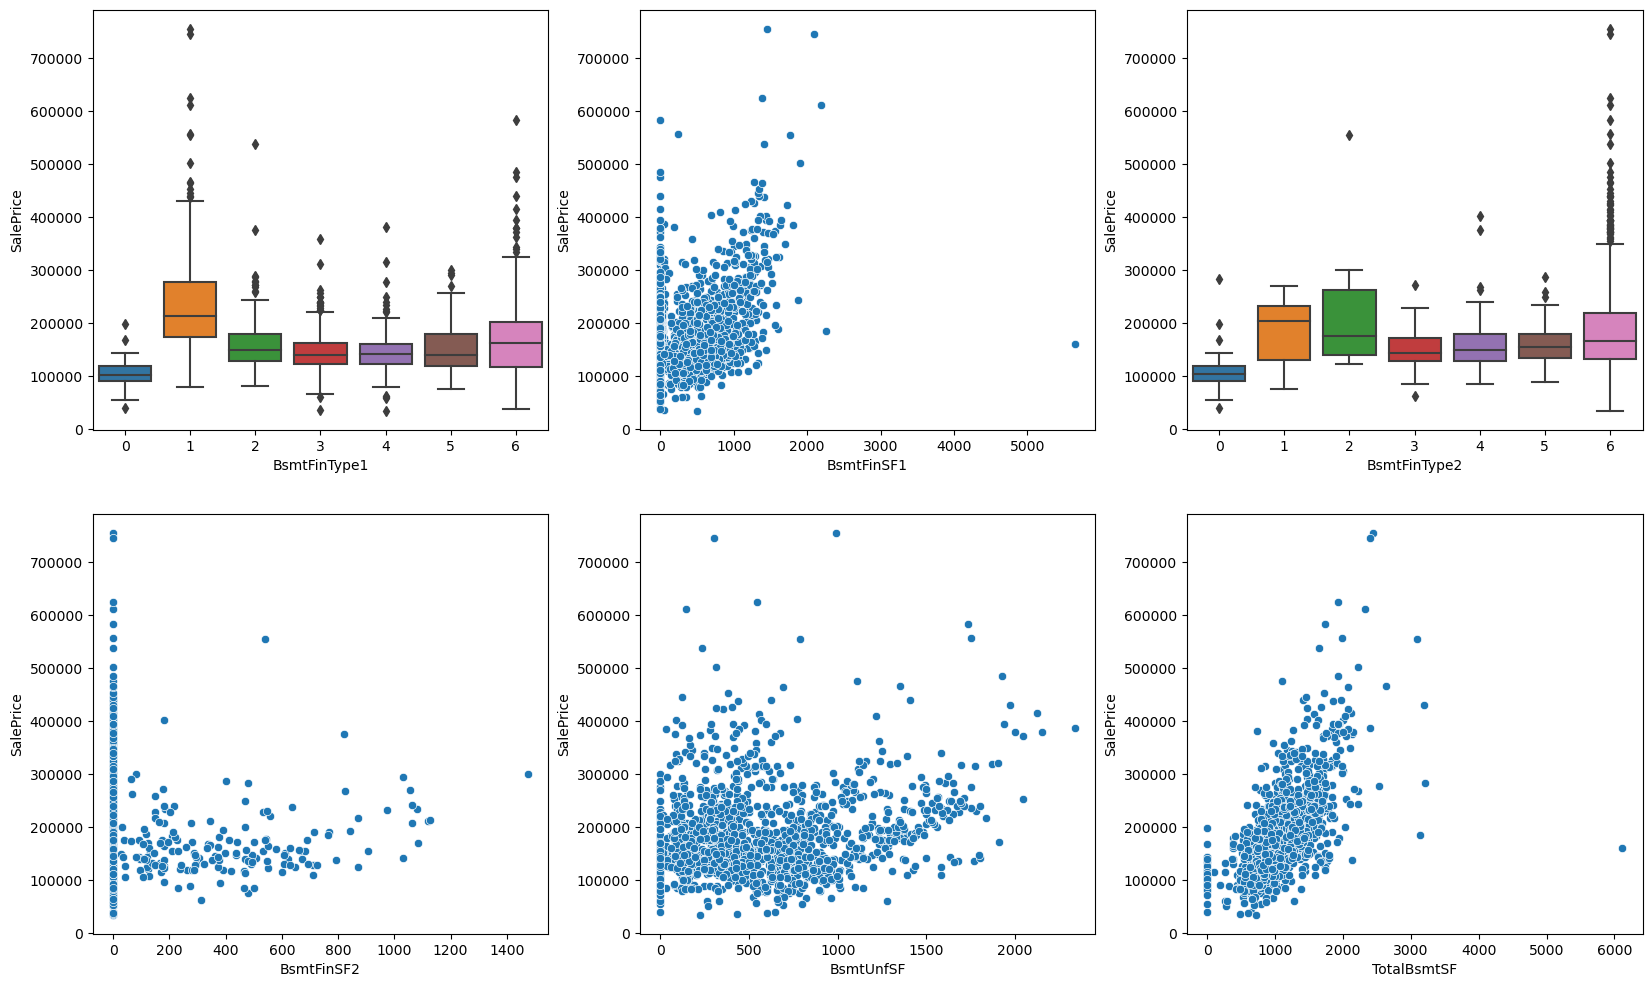

In [32]:

#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'BsmtFinType1', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.scatterplot(data = housing , x = 'BsmtFinSF1', y = 'SalePrice')
plt.subplot(2,3,3)
sns.boxplot(x = 'BsmtFinType2', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.scatterplot(data = housing , x = 'BsmtFinSF2', y = 'SalePrice')
plt.subplot(2,3,5)
sns.scatterplot(data = housing , x = 'BsmtUnfSF', y = 'SalePrice')
plt.subplot(2,3,6)
sns.scatterplot(data = housing , x = 'TotalBsmtSF', y = 'SalePrice')
plt.show()

In [33]:
# All these features show varying level of relationship and hence let's keep them for model buiding
# Features HeatingQC is ordinal variables and hence it can be converted to numerical variables
# Define mapping dictionary
HeatingQC_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['HeatingQC'] = housing['HeatingQC'].map(HeatingQC_mapping).astype(int)

In [34]:
# Let's impute the missing values in Electrical with Mix
housing['Electrical'].fillna('Mix', inplace=True)

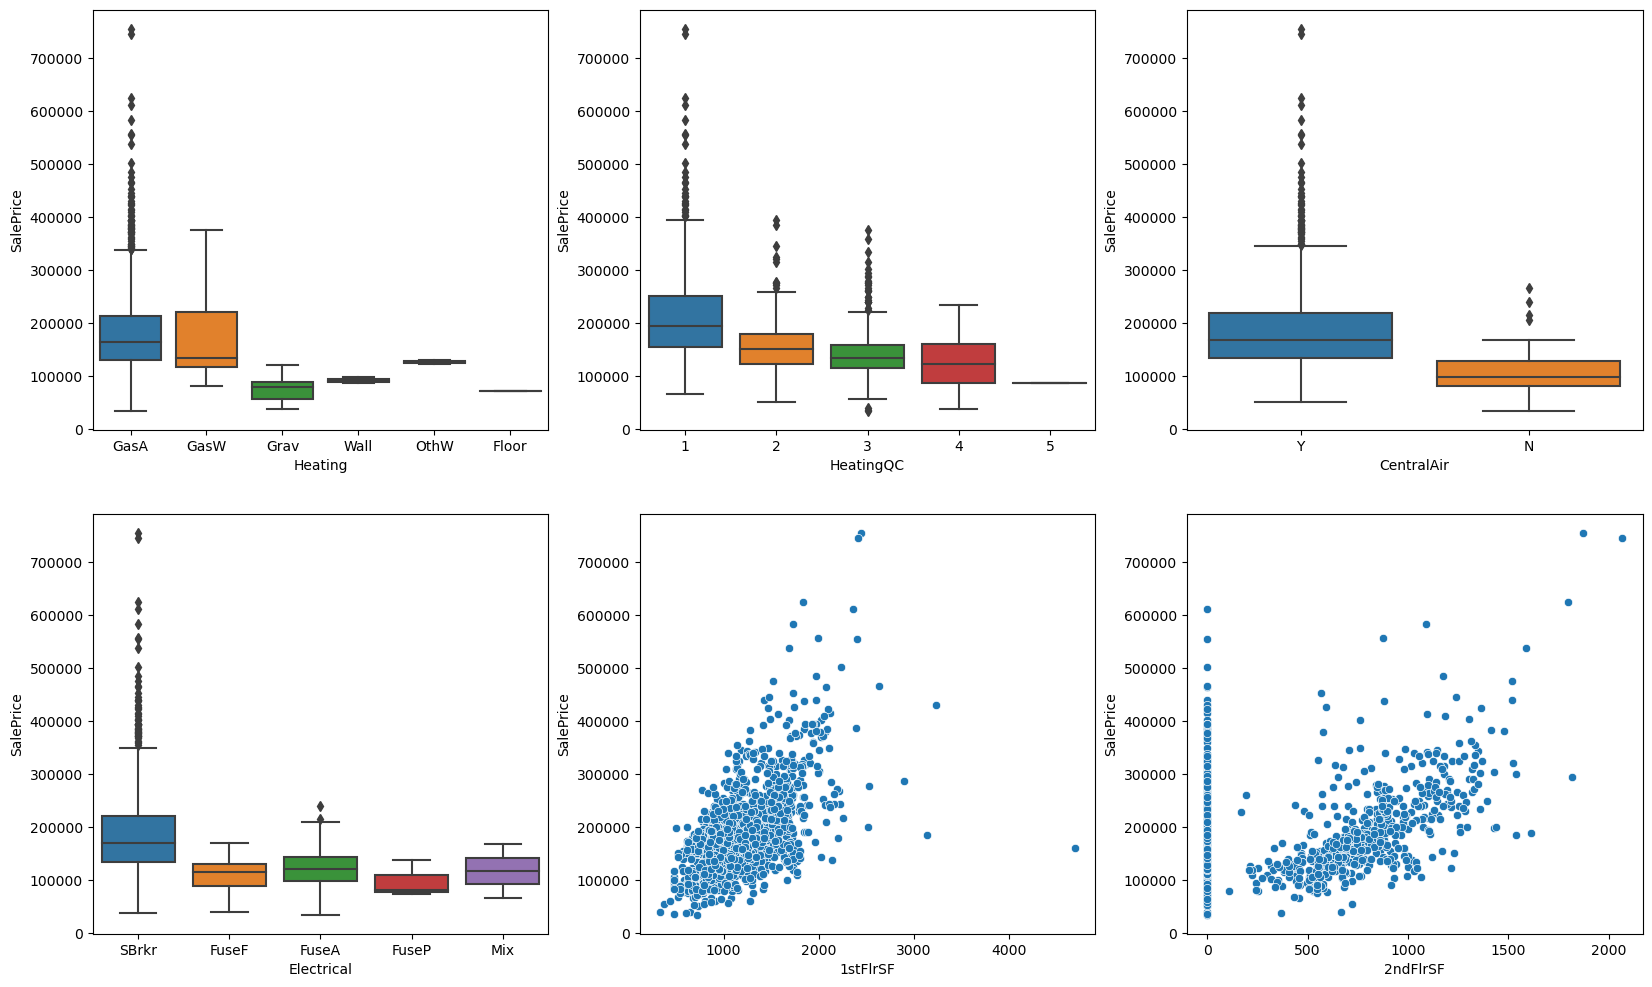

In [35]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'Heating', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'CentralAir', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'Electrical', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.scatterplot(data = housing , x = '1stFlrSF', y = 'SalePrice')
plt.subplot(2,3,6)
sns.scatterplot(data = housing , x = '2ndFlrSF', y = 'SalePrice')
plt.show()

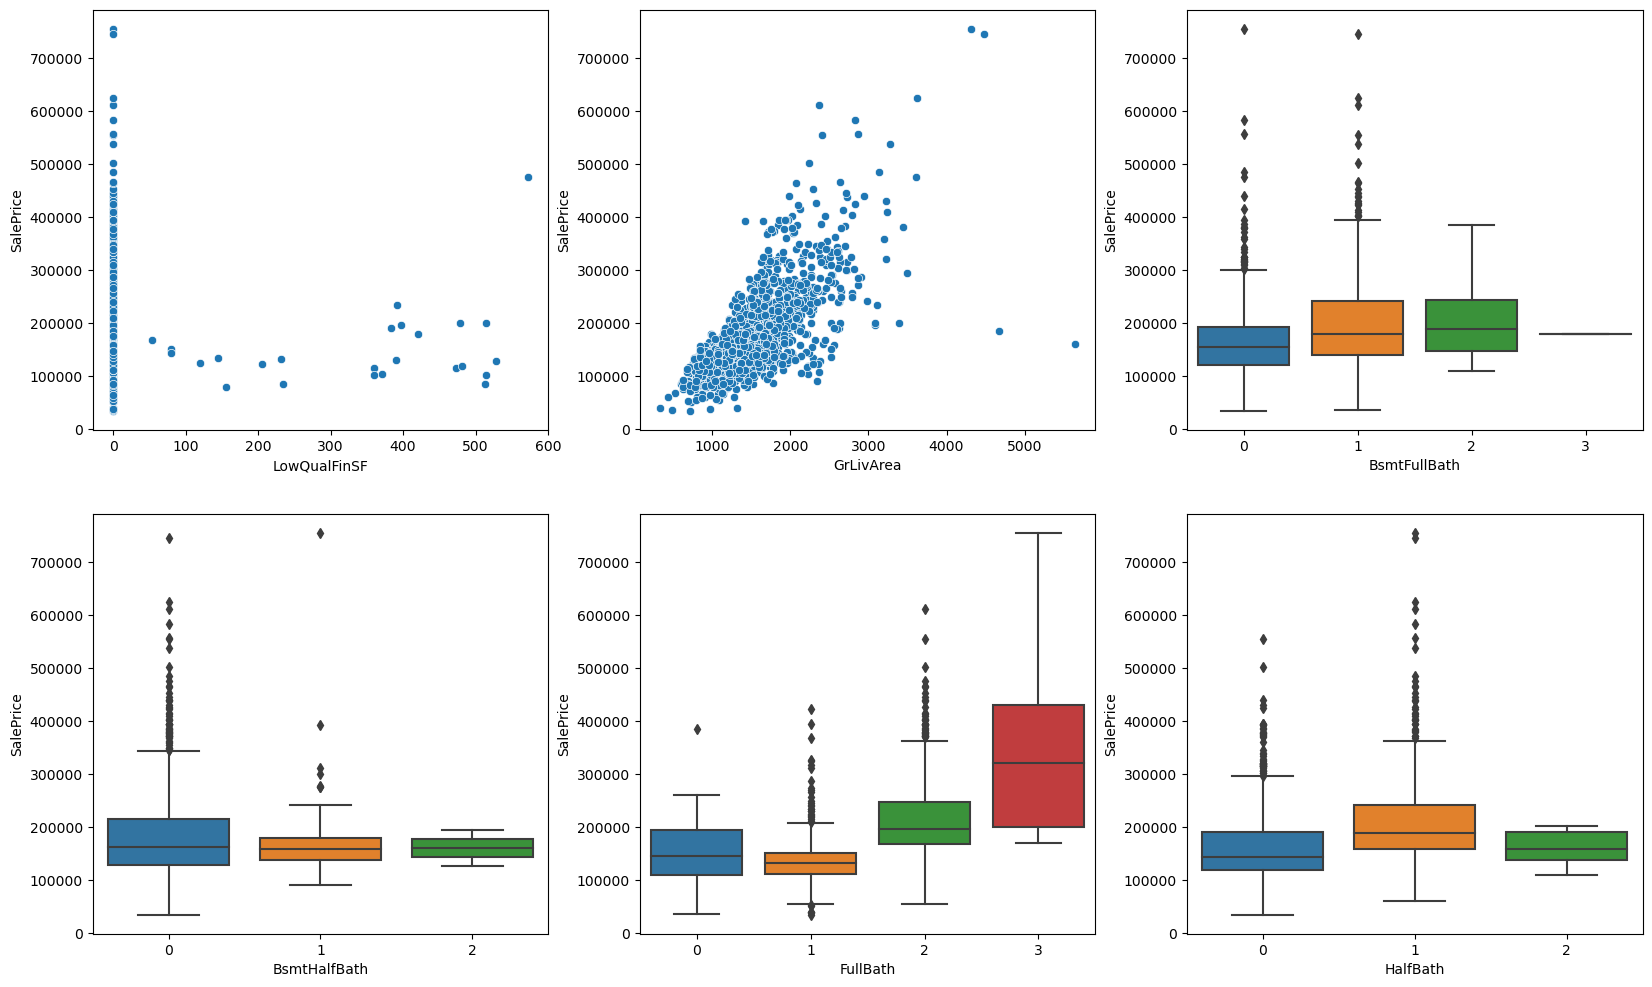

In [36]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.scatterplot(data = housing , x = 'LowQualFinSF', y = 'SalePrice')
plt.subplot(2,3,2)
sns.scatterplot(data = housing , x = 'GrLivArea', y = 'SalePrice')
plt.subplot(2,3,3)
sns.boxplot(x = 'BsmtFullBath', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'BsmtHalfBath', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'FullBath', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'HalfBath', y = 'SalePrice', data = housing)
plt.show()

In [37]:
# LowQualFinSF is 0 for maximum properties. So this can be dropped
housing.drop(columns=['LowQualFinSF'], inplace=True)

In [38]:
# Features KitchenQual & Functional are ordinal variables and hence it can be converted to numerical variables
# Define mapping dictionary
KitchenQual_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['KitchenQual'] = housing['KitchenQual'].map(KitchenQual_mapping).astype(int)

# Define mapping dictionary
Functional_mapping = {'Typ': 1, 'Min1': 2, 'Min2': 3, 'Mod': 4, 'Maj1': 5, 'Maj2': 6, 'Sev': 7, 'Sal': 8}
# Apply mapping to the column
housing['Functional'] = housing['Functional'].map(Functional_mapping).astype(int)


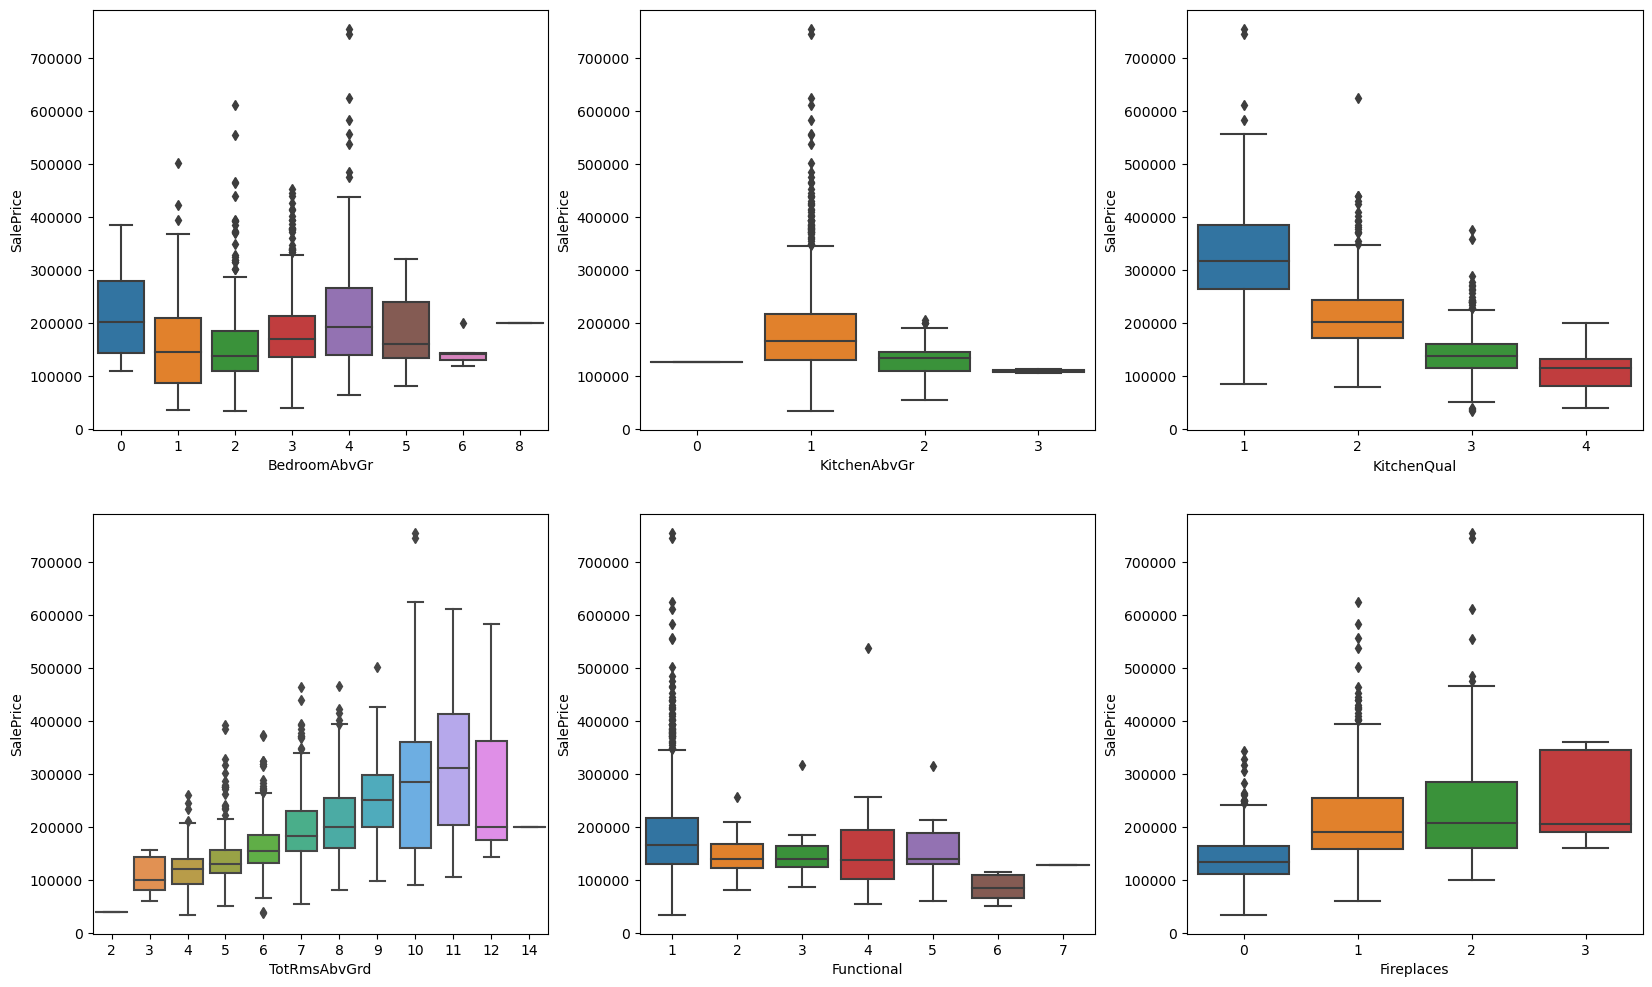

In [39]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'BedroomAbvGr', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'KitchenAbvGr', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'Functional', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'Fireplaces', y = 'SalePrice', data = housing)
plt.show()

In [40]:
# Features FireplaceQu & GarageFinish are ordinal variables and hence it can be converted to numerical variables
# Define mapping dictionary
FireplaceQu_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['FireplaceQu'] = housing['FireplaceQu'].map(FireplaceQu_mapping).fillna(0).astype(int)

# Define mapping dictionary
GarageFinish_mapping = {'Fin': 1, 'RFn': 2, 'Unf': 3}
# Apply mapping to the column
housing['GarageFinish'] = housing['GarageFinish'].map(GarageFinish_mapping).fillna(0).astype(int)


In [42]:
# Let's impute GarageType & GarageYrBlt with appropriate value  
housing['GarageType'].fillna('No_Garage', inplace=True)
housing['GarageYrBlt'].fillna(1900, inplace=True)

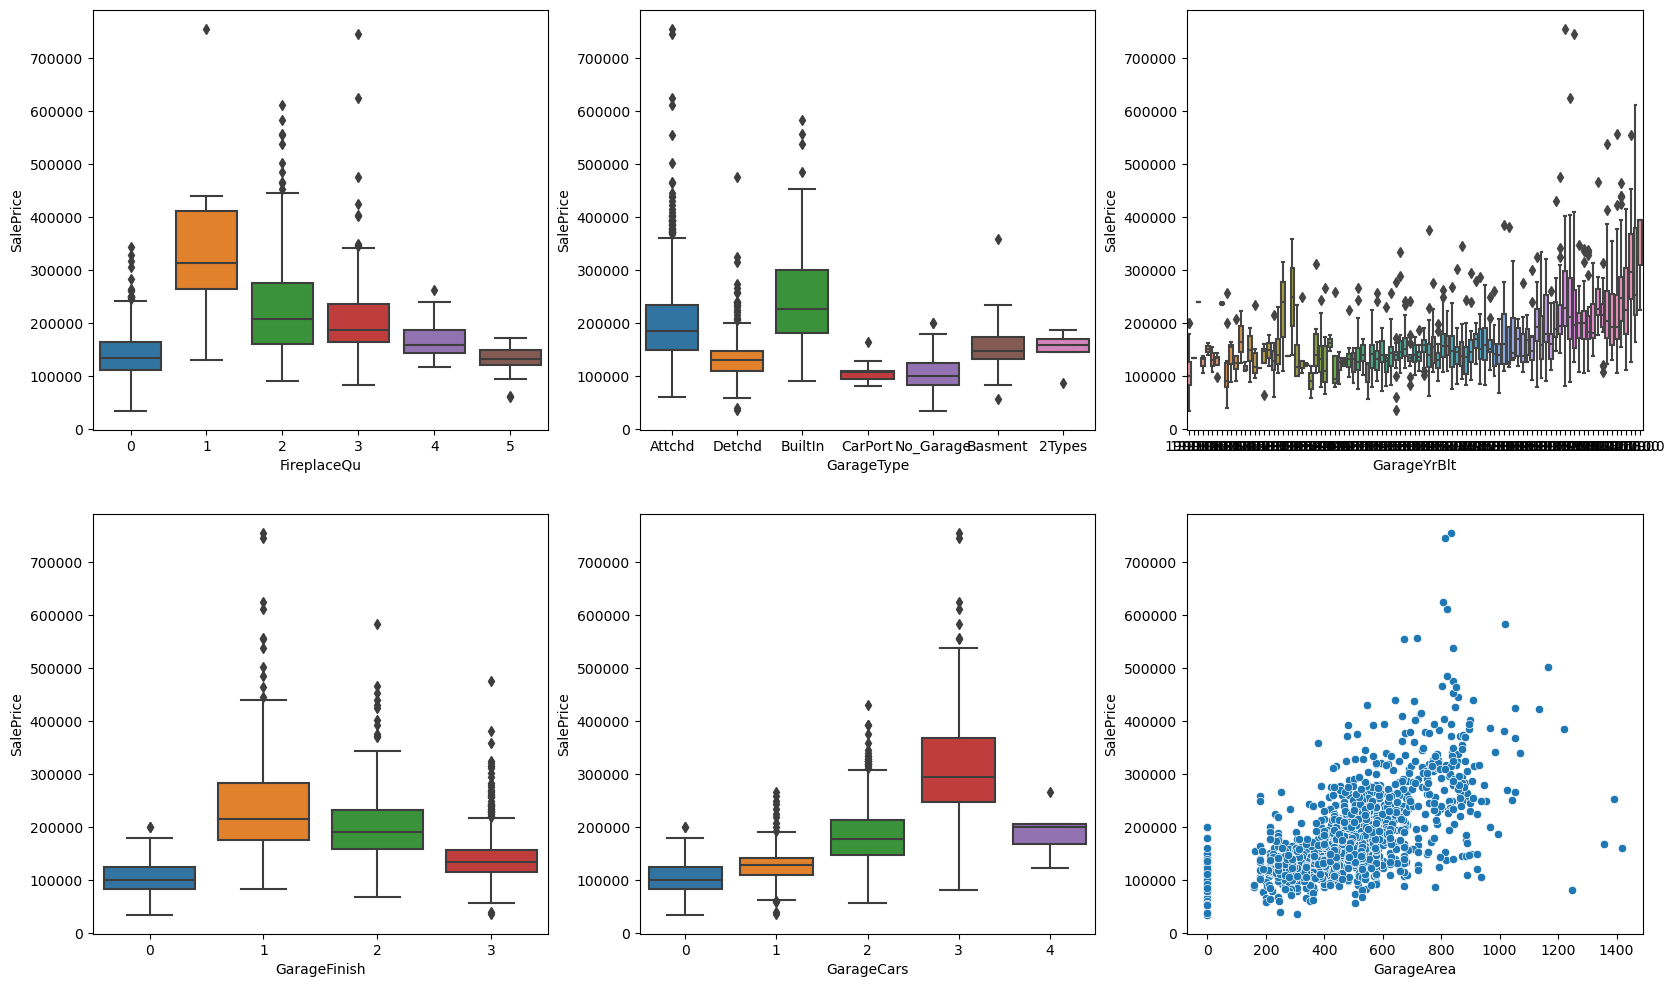

In [44]:

#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'FireplaceQu', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'GarageType', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'GarageYrBlt', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'GarageFinish', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.scatterplot(x = 'GarageArea', y = 'SalePrice', data = housing)
plt.show()

In [46]:
# Features GarageQual & GarageCond are ordinal variables and hence it can be converted to numerical variables
# Define mapping dictionary
GarageQual_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['GarageQual'] = housing['GarageQual'].map(GarageQual_mapping).fillna(0).astype(int)

# Define mapping dictionary
GarageCond_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}
# Apply mapping to the column
housing['GarageCond'] = housing['GarageCond'].map(GarageCond_mapping).fillna(0).astype(int)


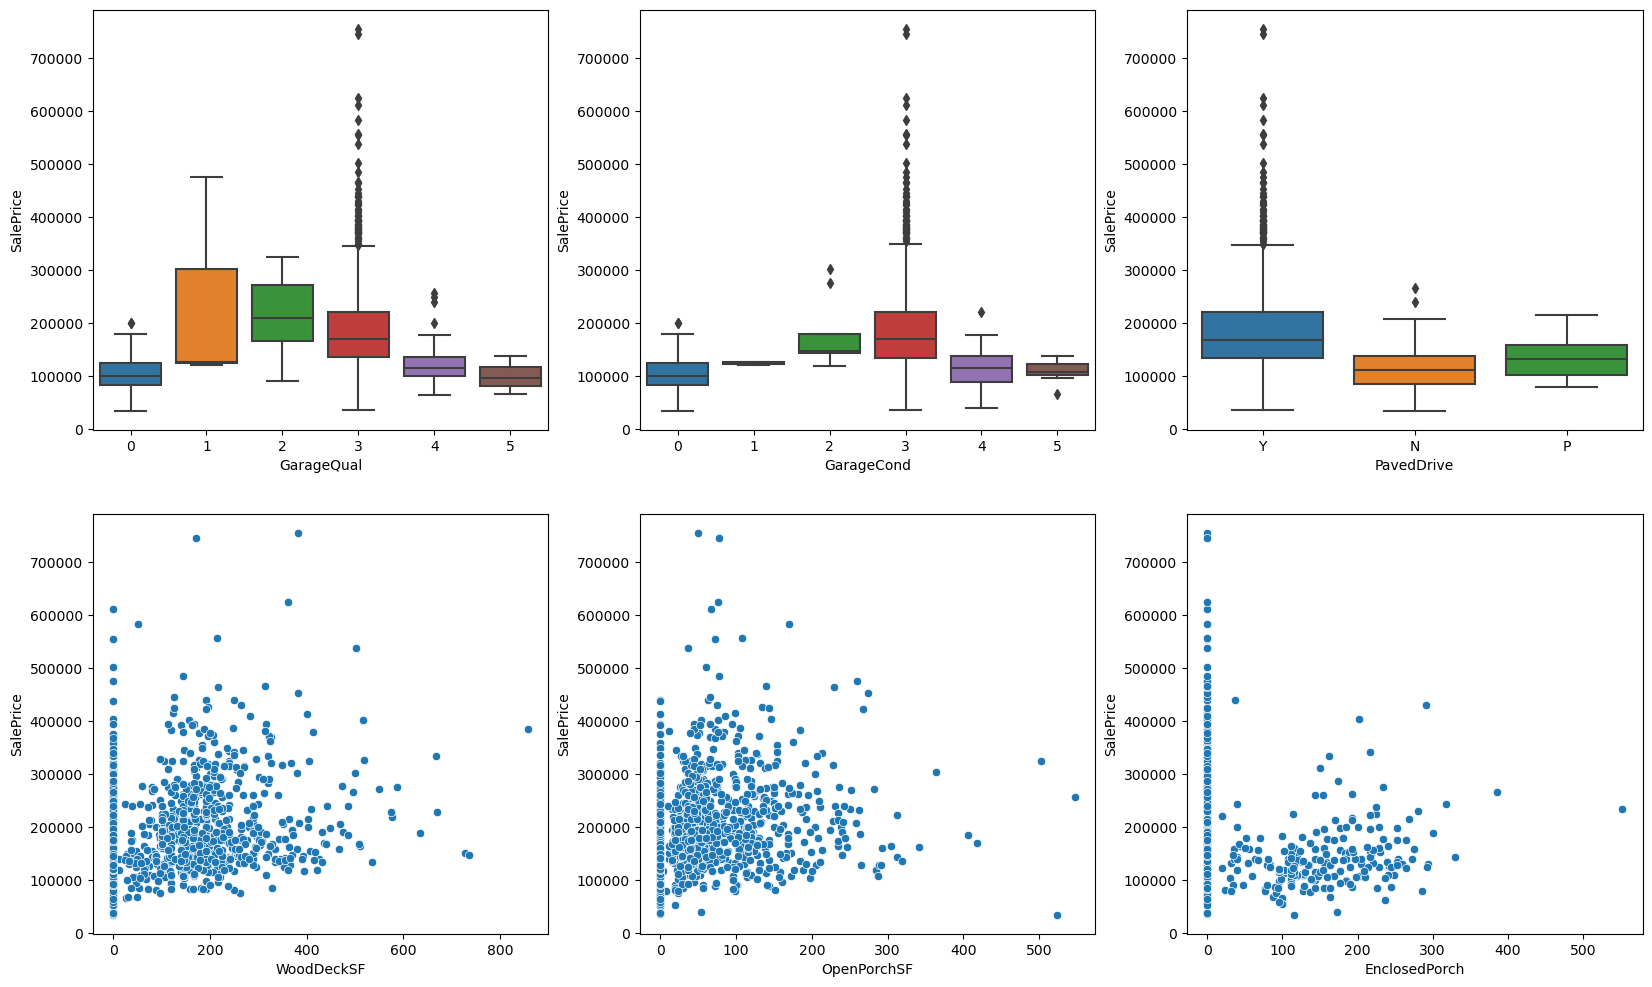

In [48]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'GarageQual', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'GarageCond', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'PavedDrive', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.scatterplot(x = 'WoodDeckSF', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.scatterplot(x = 'OpenPorchSF', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.scatterplot(x = 'EnclosedPorch', y = 'SalePrice', data = housing)
plt.show()

In [49]:
# EnclosedPorch is 0 fr 1200+ properties and ame is not showing any relationship with target.Hence can be dropped
housing.drop(columns=['EnclosedPorch'], inplace=True)

In [50]:
# Features PoolQC is ordinal variables and hence it can be converted to numerical variables

# Define mapping dictionary
PoolQC_mapping = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4}
# Apply mapping to the column
housing['PoolQC'] = housing['PoolQC'].map(PoolQC_mapping).fillna(0).astype(int)

# Impute missing value in Fence with No_Fence
housing['Fence'].fillna('No_Fence', inplace=True)


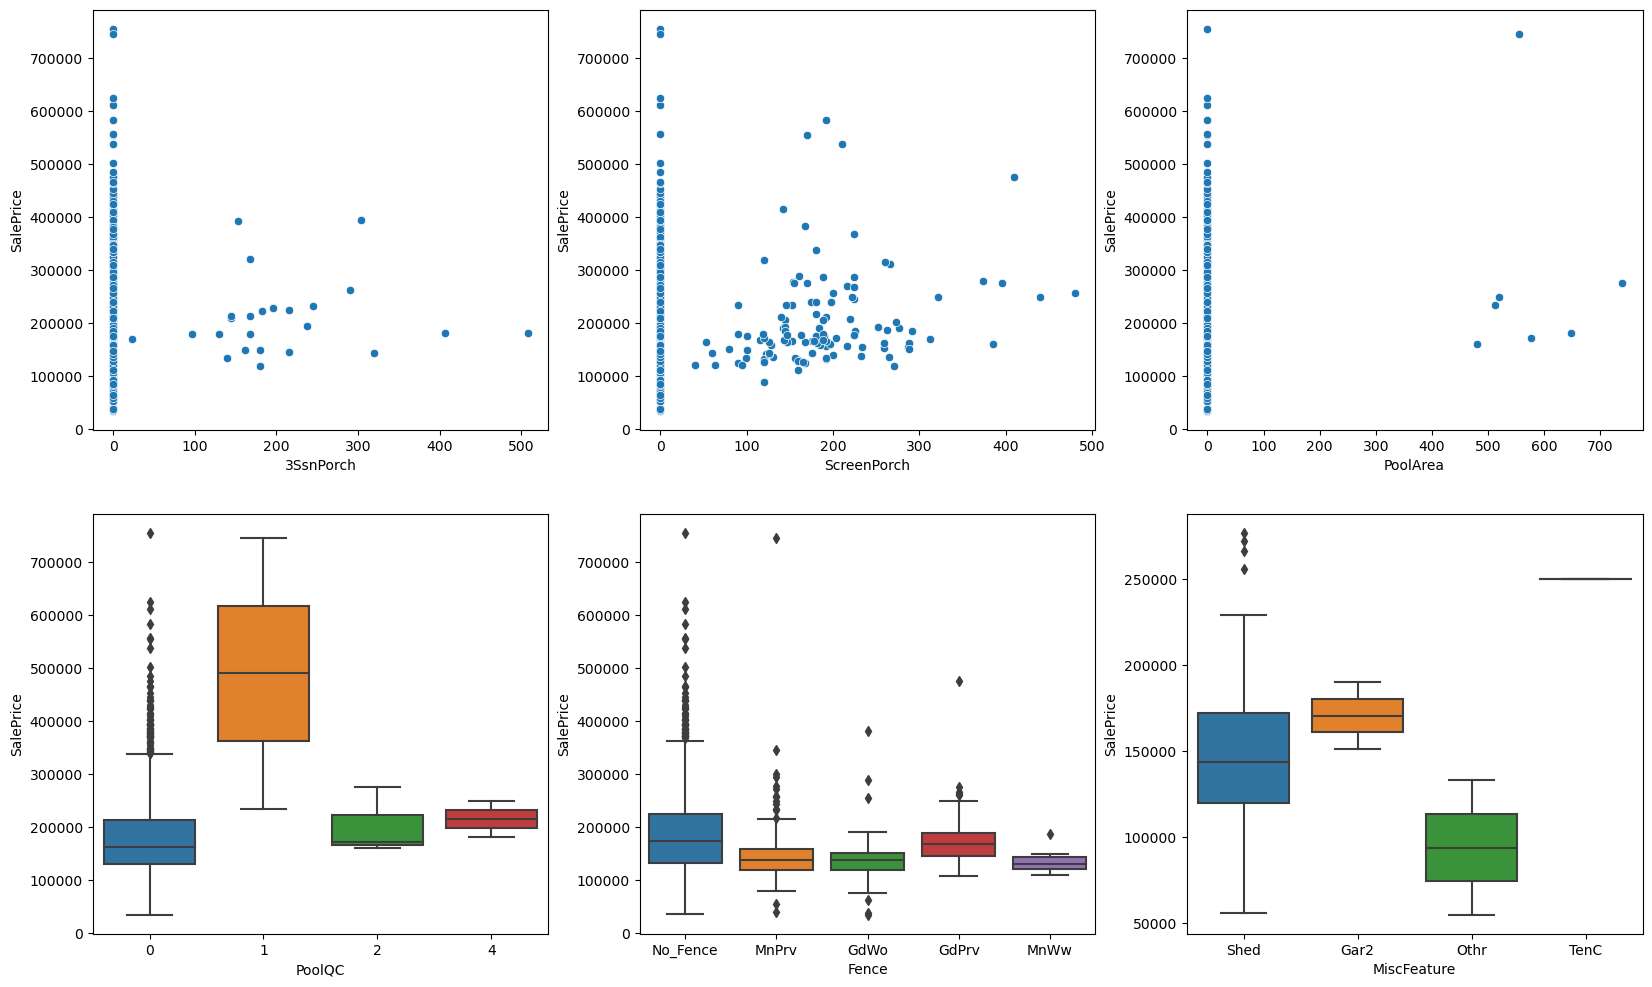

In [51]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.scatterplot(x = '3SsnPorch', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.scatterplot(x = 'ScreenPorch', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.scatterplot(x = 'PoolArea', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'PoolQC', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'Fence', y = 'SalePrice', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'MiscFeature', y = 'SalePrice', data = housing)
plt.show()

In [52]:
# Features 3SsnPorch, ScreenPorch, PoolArea & Fence have high missing values and no relationship with target variable and hence can be dropped
housing.drop(columns=['3SsnPorch'], inplace=True)
housing.drop(columns=['ScreenPorch'], inplace=True)
housing.drop(columns=['PoolArea'], inplace=True)
housing.drop(columns=['Fence'], inplace=True)

In [53]:
# Although PoolQC, MiscFeature shw some relationship, the properties with pool and misc features are veryless and hence not able to generalize for model building
housing.drop(columns=['PoolQC'], inplace=True)
housing.drop(columns=['MiscFeature'], inplace=True)

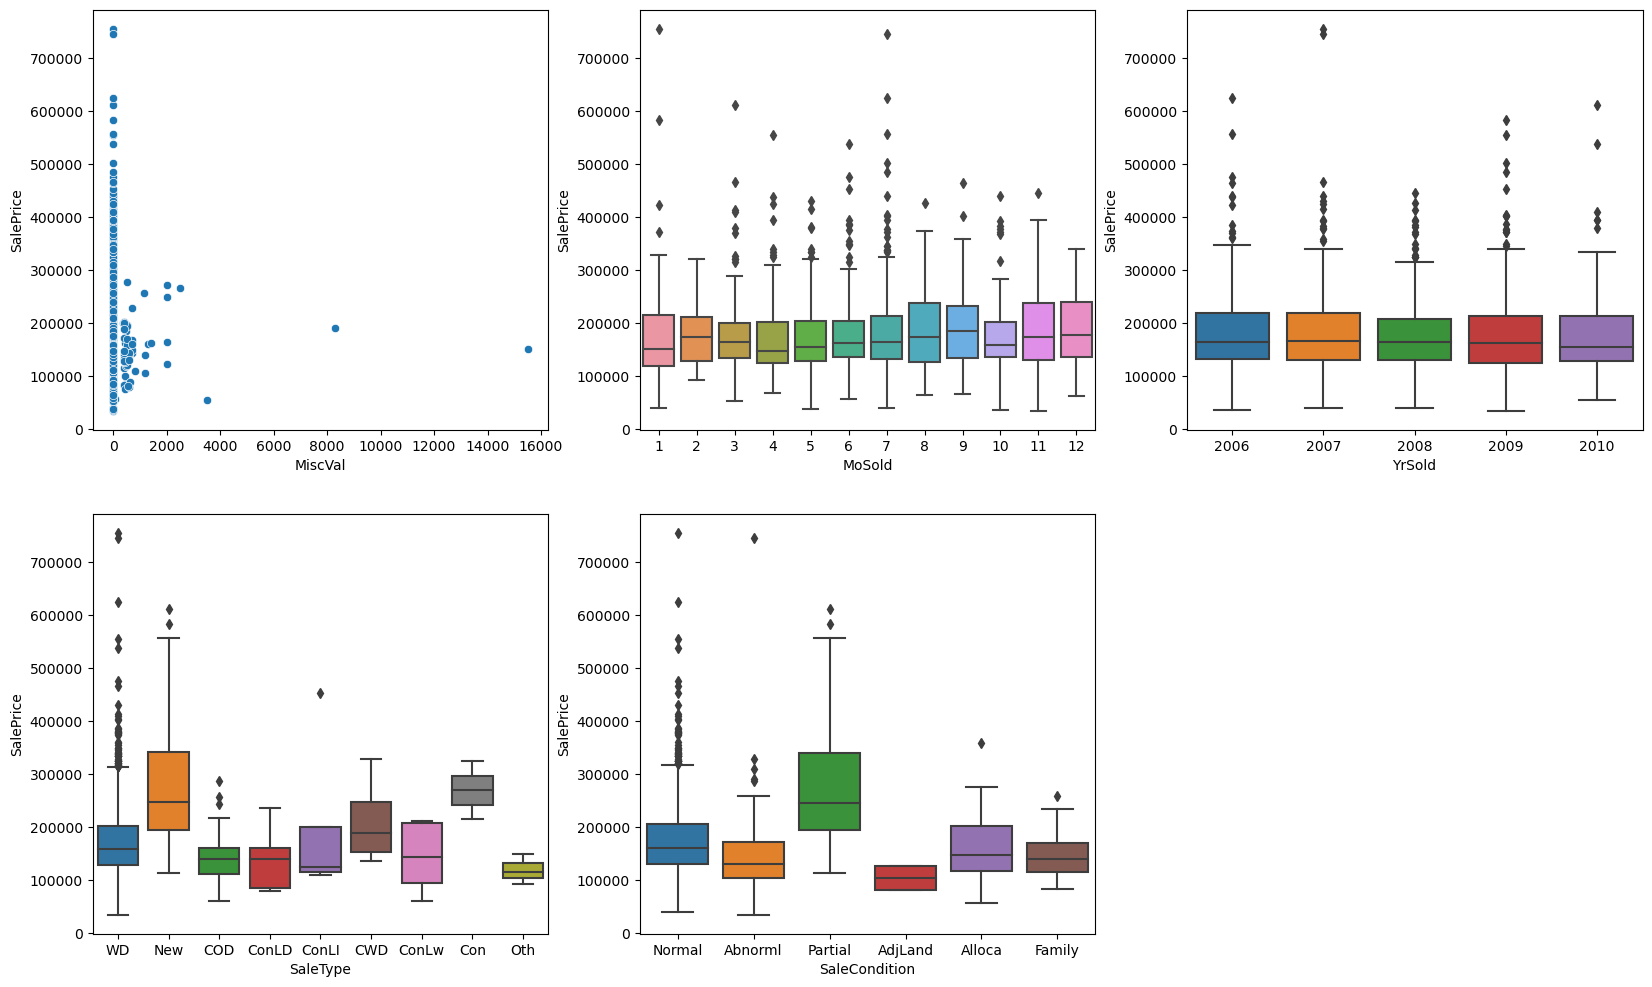

In [54]:
#Let's check the relatinship between the next 6 categorical variables witth the target variable to determine if we want to use them in the model building or not
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.scatterplot(x = 'MiscVal', y = 'SalePrice', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'MoSold', y = 'SalePrice', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'YrSold', y = 'SalePrice', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'SaleType', y = 'SalePrice', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'SaleCondition', y = 'SalePrice', data = housing)
plt.show()

In [55]:
# Features MiscVal have high missing value and MoSold & YrSold do not show relationship with target variable and hence can be dropped
housing.drop(columns=['MiscVal'], inplace=True)
housing.drop(columns=['MoSold'], inplace=True)
housing.drop(columns=['YrSold'], inplace=True)

In [62]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSZoning        1460 non-null   object 
 1   LotFrontage     1460 non-null   float64
 2   Street          1460 non-null   object 
 3   Utilities       1460 non-null   object 
 4   Neighborhood    1460 non-null   object 
 5   Condition1      1460 non-null   object 
 6   Condition2      1460 non-null   object 
 7   BldgType        1460 non-null   object 
 8   HouseStyle      1460 non-null   object 
 9   OverallQual     1460 non-null   int64  
 10  OverallCond     1460 non-null   int64  
 11  YearBuilt       1460 non-null   int64  
 12  YearRemodAdd    1460 non-null   int64  
 13  RoofMatl        1460 non-null   object 
 14  Exterior1st     1460 non-null   object 
 15  Exterior2nd     1460 non-null   object 
 16  MasVnrType      1460 non-null   object 
 17  ExterQual       1460 non-null   i

### Dummy variable

In [58]:
# Convert 'MSSubClass' to categorical dtype
housing['MSSubClass'] = housing['MSSubClass'].astype('category')

# Create dummy variables for 'MSSubClass'
dummy_MSSubClass = pd.get_dummies(housing['MSSubClass'], prefix='MSSubClass')
dummy_MSSubClass = dummy_MSSubClass.astype(int)

# Concatenate dummy variables with original dataframe
housing = pd.concat([housing, dummy_MSSubClass], axis=1)

# Drop the original 'MSSubClass' column
housing.drop(columns=['MSSubClass'], inplace=True)

In [63]:
# Display the updated dataframe
pd.set_option('display.max_columns', None)
housing.head()

,MSZoning,LotFrontage,Street,Utilities,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,RL,65.0,Pave,AllPub,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,CompShg,VinylSd,VinylSd,BrkFace,2,3,PConc,2,3,4,1,706,6,0,150,856,GasA,1,Y,SBrkr,856,854,1710,1,0,2,1,3,1,2,8,1,0,0,Attchd,2003.0,2,2,548,3,3,Y,0,61,WD,Normal,208500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,RL,80.0,Pave,AllPub,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,CompShg,MetalSd,MetalSd,None,3,3,CBlock,2,3,1,2,978,6,0,284,1262,GasA,1,Y,SBrkr,1262,0,1262,0,1,2,0,3,1,3,6,1,1,3,Attchd,1976.0,2,2,460,3,3,Y,298,0,WD,Normal,181500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,RL,68.0,Pave,AllPub,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,CompShg,VinylSd,VinylSd,BrkFace,2,3,PConc,2,3,3,1,486,6,0,434,920,GasA,1,Y,SBrkr,920,866,1786,1,0,2,1,3,1,2,6,1,1,3,Attchd,2001.0,2,2,608,3,3,Y,0,42,WD,Normal,223500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,RL,60.0,Pave,AllPub,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,CompShg,Wd Sdng,Wd Shng,None,3,3,BrkTil,3,2,4,2,216,6,0,540,756,GasA,2,Y,SBrkr,961,756,1717,1,0,1,0,3,1,2,7,1,1,2,Detchd,1998.0,3,3,642,3,3,Y,0,35,WD,Abnorml,140000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,RL,84.0,Pave,AllPub,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,CompShg,VinylSd,VinylSd,BrkFace,2,3,PConc,2,3,2,1,655,6,0,490,1145,GasA,1,Y,SBrkr,1145,1053,2198,1,0,2,1,4,1,2,9,1,1,3,Attchd,2000.0,2,3,836,3,3,Y,192,84,WD,Normal,250000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [64]:
# List of variables with multiple categories
multi_categories = ['MSZoning', 'Street', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofMatl', 'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir','Electrical', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']

# Convert variables with multiple categories into dummy variables
dummy_multi = pd.get_dummies(housing[multi_categories], drop_first=True)

# Convert boolean dummy variables into integers (0 or 1)
dummy_multi = dummy_multi.astype(int)

# Concatenate the dummy variables with the original dataframe
housing = pd.concat([housing.drop(multi_categories, axis=1), dummy_multi], axis=1)

In [65]:
# Display the updated dataframe
housing.head()

,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Utilities_NoSeWa,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,7,5,2003,2003,2,3,2,3,4,1,706,6,0,150,856,1,856,854,1710,1,0,2,1,3,1,2,8,1,0,0,2003.0,2,2,548,3,3,0,61,208500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,6,8,1976,1976,3,3,2,3,1,2,978,6,0,284,1262,1,1262,0,1262,0,1,2,0,3,1,3,6,1,1,3,1976.0,2,2,460,3,3,298,0,181500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,7,5,2001,2002,2,3,2,3,3,1,486,6,0,434,920,1,920,866,1786,1,0,2,1,3,1,2,6,1,1,3,2001.0,2,2,608,3,3,0,42,223500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [66]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 186 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(2), int32(160), int64(24)
memory usage: 1.2 MB


## Splitting the Data into Training and Testing Sets

In [67]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(housing, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [69]:
scaler = MinMaxScaler()

In [70]:
df_train.head()

,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Utilities_NoSeWa,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,67.0,5,6,1925,1950,3,3,3,3,4,4,468,6,0,396,864,3,864,0,864,1,0,1,0,2,1,3,5,1,0,0,1900.0,0,0,0,0,0,0,0,98000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
318,90.0,7,5,1993,1993,2,3,2,3,1,1,987,6,0,360,1347,1,1372,1274,2646,1,0,2,1,4,1,2,9,1,1,3,1993.0,2,3,656,3,3,340,60,260000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
239,52.0,6,4,1945,1950,3,3,3,4,4,5,94,6,0,641,735,3,798,689,1487,0,0,1,1,3,1,3,7,1,1,2,1949.0,3,1,220,3,3,0,140,113000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [73]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF' ,'2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath' ,'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [74]:
df_train.describe()

,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Utilities_NoSeWa,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1

In [75]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 1436 to 266
Columns: 186 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(40), int32(146)
memory usage: 390.1 KB


In [78]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [79]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [80]:
# num of max features
len(X_train.columns)

185

### Step 3: Model Building
The data has 185 features. Let's build the model with all 185 parameters and check the performance. 

In [131]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=185)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_train
y_pred_train = rfe.predict(X_train)
r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
print(r2_train)

0.9260508347511486


In [132]:
# predict prices of X_test
y_pred_test = rfe.predict(X_test)
r2_test = sklearn.metrics.r2_score(y_test, y_pred_test)
print(r2_test)

-1.693269005879829e+23


## Inference - Model 1:
Clearly the model is overfit. Let's use the cross-validation to fine tune the no of features

### K-Fold cross validation
We will use the K-Fold cross validation strategy to check optimal hyperparameter

In [117]:
# k-fold CV (using all the 185 variables)
lm = LinearRegression()
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([-1.57269267e+20, -1.03459423e+20, -8.05952189e+20, -2.42392837e+16,
       -4.42653942e+22])

In [125]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 185))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 184 candidates, totalling 920 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [126]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.519456,0.359323,0.009370,0.012491,1,{'n_features_to_select': 1},2.284051e-01,4.132935e-01,6.990096e-01,5.946438e-01,5.969407e-01,5.064585e-01,1.667531e-01,7,0.411226,0.368406,0.598000,0.625526,0.624422,0.525516,0.112057
1,1.345897,0.037798,0.006254,0.007660,2,{'n_features_to_select': 2},3.426934e-01,4.123497e-01,6.927365e-01,5.953230e-01,5.967801e-01,5.279765e-01,1.297033e-01,4,0.653367,0.383617,0.612871,0.639415,0.637832,0.585420,0.101742
2,1.349916,0.033653,0.009383,0.007661,3,{'n_features_to_select': 3},3.021134e-01,4.122525e-01,6.926717e-01,5.954635e-01,5.623394e-01,5.129681e-01,1.386649e-01,5,0.691283,0.386284,0.612975,0.640121,0.642236,0.594580,0.107165
3,1.337701,0.026814,0.006252,0.007657,4,{'n_features_to_select': 4},5.479335e-01,4.121819e-01,6.929305e-01,5.955101e-01,5.623356e-01,5.621783e-01,9.045333e-02,1,0.800467,0.386442,0.613064,0.640268,0.642330,0.616514,0.132676
4,1.353042,0.041458,0.003124,0.006248,5,{'n_features_to_select': 5},4.974658e-01,4.121482e-01,6.929266e-01,5.955135e-01,5.623241e-01,5.520756e-01,9.422612e-02,2,0.824080,0.386478,0.613070,0.640270,0.642337,0.621247,0.139378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.117045,0.009676,0.004727,0.006271,180,{'n_features_to_select': 180},-6.354978e+20,-4.395117e+18,-8.245630e+21,-2.959735e+19,-1.583300e+21,-2.099684e+21,3.125976e+21,75,0.931301,0.925167,0.931019,0.934642,0.935311,0.931488,0.003599
180,0.097463,0.016391,0.006249,0.007654,181,{'n_features_to_select': 181},-9.266628e+20,-3.046968e+18,-7.288575e+20,-2.187724e+18,-1.090433e+23,-2.214081e+22,4.345285e+22,137,0.926781,0.930468,0.930975,0.934801,0.935001,0.931605,0.003056
181,0.074985,0.006249,0.009375,0.007654,182,{'n_features_to_select': 182},-7.166574e+21,-2.356854e+18,-1.397513e+23,-6.614357e+14,-5.455766e+22,-4.029558e+22,5.373948e+22,155,0.925253,0.930423,0.930841,0.936115,0.935233,0.931573,0.003894
182,0.062497,0.009885,0.006249,0.007654,183,{'n_features_to_select': 183},-1.220635e+19,-2.316757e+21,-2.416475e+22,-2.975167e+19,-4.441106e+23,-9.412682e+22,1.752280e+23,171,0.931488,0.927548,0.930952,0.929495,0.933170,0.930531,0.001899


In [135]:
cv_results.to_excel(r'C:\Users\Amarjit\CV_AR_Model2.xlsx', index=False)

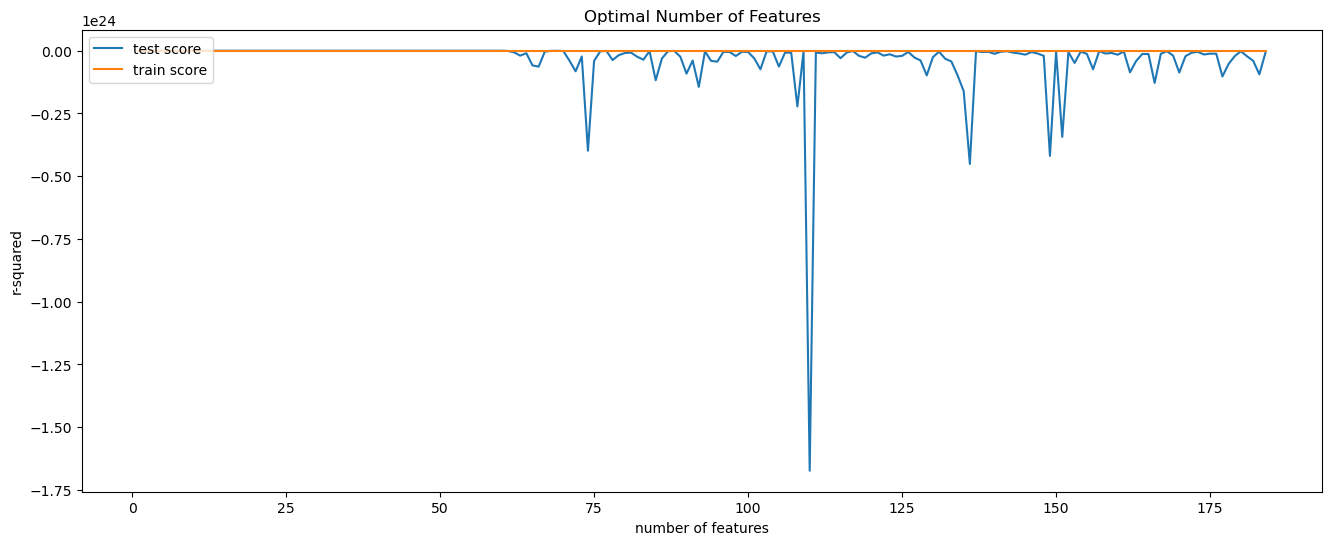

In [127]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [128]:
model_cv.best_estimator_

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [129]:
# # fit the model
# model_cv.fit(X_train, y_train)

# get the best estimator (model) from the grid search
best_rfe_model = model_cv.best_estimator_

# get the ranking of features (1 = selected, 0 = not selected)
feature_ranking = best_rfe_model.support_

# get the indices of selected features
selected_feature_indices = np.where(feature_ranking)[0]

# get the names of selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# print the selected feature names
print("Selected features:", selected_feature_names)


Selected features: Index(['OverallQual', 'RoofMatl_Membran', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShngl'],
      dtype='object')


Let's try to run the model with optimal number of features as per RFE aproach 

In [136]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=4)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_train
y_pred_train = rfe.predict(X_train)
r2 = sklearn.metrics.r2_score(y_train, y_pred_train)
print(r2)

0.6309091992259381


Let's predict the test R2 score

In [137]:
# predict prices of X_test
y_pred_test = rfe.predict(X_test)
r2_test = sklearn.metrics.r2_score(y_test, y_pred_test)
print(r2_test)

0.6387510222604784


## Inference - Model 2:
With K-Cross validation, we can clearly see that with less no of features the model is simple and as expected the model accuracy is low. However we can see that model accuracy on train data and test data are similar. It means the model is generalized and robus. 

The model predicts about 63% of prices with following four features - 
1. OverallQual
2. RoofMatl_Membran
3. RoofMatl_Tar&Grv
4. RoofMatl_WdShngl

### Model tuning with Lasso regression

In [138]:
# Let's use random values of lambdas to test the model efficacy

from sklearn.linear_model import Lasso

lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
for i in lambdas:
    # Create and fit Lasso regression model
    lasso = Lasso(alpha=i)  # You can adjust the regularization parameter alpha as needed
    lasso.fit(X_train, y_train)
    
    # Create RFE with Lasso model
    rfe = RFE(lasso, n_features_to_select=254)
    rfe.fit(X_train, y_train)
    
    # Predict prices of X_train
    y_pred_train = rfe.predict(X_train)
    r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
    print("R2 Score on Train Data:", r2_train)

R2 Score on Train Data: 0.9295975399973233
R2 Score on Train Data: 0.9295673997545606
R2 Score on Train Data: 0.9277898547114113
R2 Score on Train Data: 0.8854790159253214
R2 Score on Train Data: 0.8223385935026012
R2 Score on Train Data: 0.3338900496798304
R2 Score on Train Data: 0.0
R2 Score on Train Data: 0.0
R2 Score on Train Data: 0.0


### Finding optimal value of lambda
Let's use GridSearchCV method to find the optimal value of lambda

In [111]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Define a range of alpha values to try
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

# Create a Lasso regression model
lasso = Lasso()

# Define the grid of hyperparameters to search
param_grid = {'alpha': alphas}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Get the best alpha value found during cross-validation
best_alpha = grid_search.best_params_['alpha']

# Create and fit a Lasso regression model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)
print("Best Alpha using lasso is: ", best_alpha)

# Evaluate the model on the training set
y_train_pred = lasso_best.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print("R-squared on the training set:", r2_train)

# Evaluate the model on the test set
y_test_pred = lasso_best.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print("R-squared on the test set:", r2_test)


Best Alpha using lasso is:  0.001
R-squared on the training set: 0.8223385935026012
R-squared on the test set: 0.8064809020296675


### Optimal value of lambda with Lasso regression is 0.001

 - Let's find the best feature coefficients 

In [173]:
# Create and fit Lasso regression model
lasso = Lasso(alpha=0.001)  # You can adjust the regularization parameter alpha as needed
lasso.fit(X_train, y_train)
    
# Create RFE with Lasso model
rfe = RFE(lasso, n_features_to_select=185)
rfe.fit(X_train, y_train)
    
# Predict prices of X_train
y_pred_train = rfe.predict(X_train)
r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
print("R2 Score on Train Data:", r2_train)

R2 Score on Train Data: 0.8223385935026012


In [174]:
# Get the coefficients of the Lasso model
lasso_coefs = lasso.coef_

# Print the coefficients
print("Coefficients of the Lasso Regression Model:")
for feature, coef in zip(X_train.columns, lasso_coefs):
    print(f"{feature}: {coef}")

Coefficients of the Lasso Regression Model:
LotFrontage: 0.0
OverallQual: 0.16994864443247323
OverallCond: 0.0
YearBuilt: 0.0
YearRemodAdd: 0.009434818497522285
ExterQual: -0.02641422547519097
ExterCond: -0.0
BsmtQual: -0.0037945117136071616
BsmtCond: 0.0
BsmtExposure: -0.04659412347519109
BsmtFinType1: -0.014456936622089092
BsmtFinSF1: 0.0
BsmtFinType2: 0.0
BsmtFinSF2: 0.0
BsmtUnfSF: 0.0
TotalBsmtSF: 0.0
HeatingQC: -0.0
1stFlrSF: 0.0
2ndFlrSF: 0.0
GrLivArea: 0.23980803061607217
BsmtFullBath: 0.0030944166358539867
BsmtHalfBath: 0.0
FullBath: 0.0
HalfBath: 0.0
BedroomAbvGr: 0.0
KitchenAbvGr: -0.0
KitchenQual: -0.049975798275256576
TotRmsAbvGrd: 0.010142126895000948
Functional: -0.0
Fireplaces: 0.03690874837866167
FireplaceQu: 0.0
GarageYrBlt: 0.0
GarageFinish: -0.013825996835356034
GarageCars: 0.05820806969452383
GarageArea: 0.0
GarageQual: 0.0
GarageCond: 0.0
WoodDeckSF: 0.0
OpenPorchSF: 0.0
MSSubClass_20: 0.018198037371889433
MSSubClass_30: -0.0
MSSubClass_40: 0.0
MSSubClass_45: -0.0


In [175]:
# Get the coefficients and feature names
coefficients = lasso.coef_
feature_names = X_train.columns

# Create a DataFrame to store feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['AbsCoefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='AbsCoefficient', ascending=False)

# Select the top features
top_features = coefficients_df.head(15)

print("Top predictor features with their coefficients:")
print(top_features)


Top predictor features with their coefficients:
                  Feature  Coefficient  AbsCoefficient
19              GrLivArea     0.239808        0.239808
1             OverallQual     0.169949        0.169949
74   Neighborhood_NoRidge     0.062858        0.062858
33             GarageCars     0.058208        0.058208
26            KitchenQual    -0.049976        0.049976
9            BsmtExposure    -0.046594        0.046594
75   Neighborhood_NridgHt     0.037678        0.037678
29             Fireplaces     0.036909        0.036909
5               ExterQual    -0.026414        0.026414
39          MSSubClass_20     0.018198        0.018198
10           BsmtFinType1    -0.014457        0.014457
32           GarageFinish    -0.013826        0.013826
177          SaleType_New     0.011679        0.011679
27           TotRmsAbvGrd     0.010142        0.010142
4            YearRemodAdd     0.009435        0.009435


In [176]:
# Count the number of rows where AbsCoefficient is non-zero
non_zero_count = (coefficients_df['AbsCoefficient'] != 0).sum()

print("Number of rows where AbsCoefficient is non-zero:", non_zero_count)

Number of rows where AbsCoefficient is non-zero: 24


### Assumptions of the linear regression
Now let's validate Assumptions of the linear regression:
- Linear relationship between dependant and the independant variable
- Error terms should be independant
- Error terms should be normally distributed
- Error terms should have equal variance

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [177]:
# Predict prices of X_train
y_pred_train = rfe.predict(X_train)
r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
print("R2 Score on Train Data:", r2_train)

# Predict prices of X_test
y_pred_test = rfe.predict(X_test)
r2_test = sklearn.metrics.r2_score(y_test, y_pred_test)
print("R2 Score on Test Data:", r2_test)


R2 Score on Train Data: 0.8223385935026012
R2 Score on Test Data: 0.8064809020296675


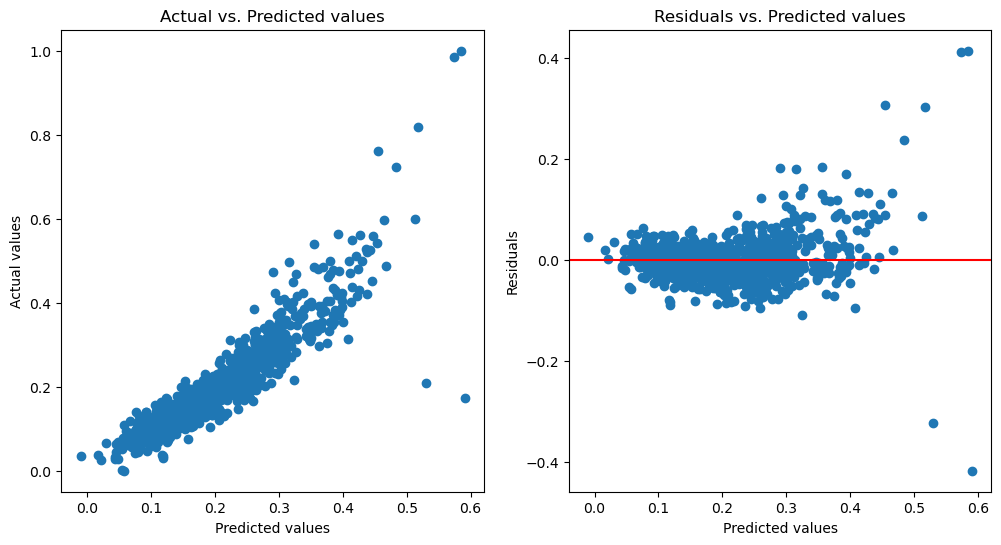

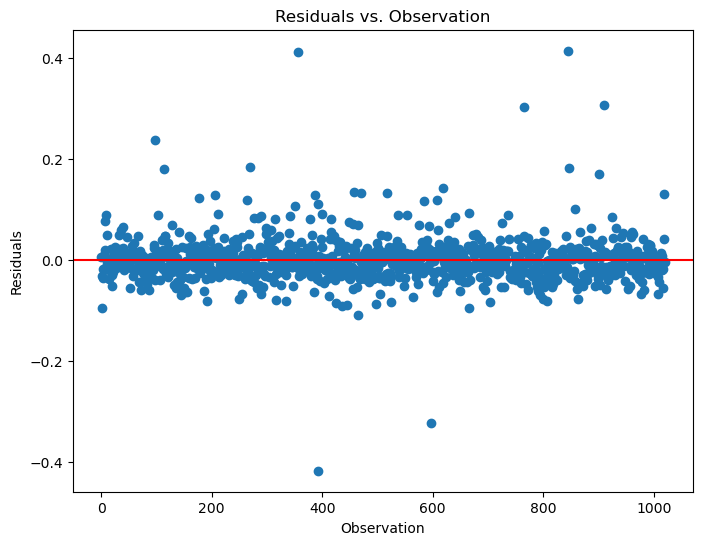

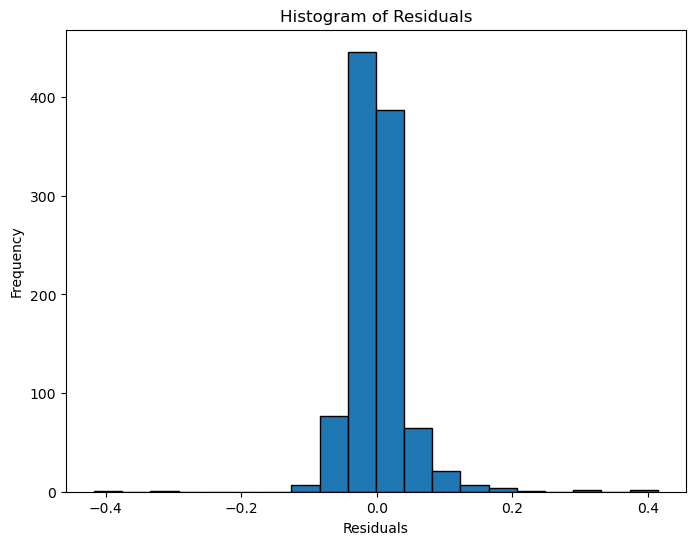

In [178]:
# Validate assumptions of linear regression
def validate_assumptions(y_true, y_pred, residuals):
    # Linear relationship
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, y_true)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title("Actual vs. Predicted values")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted values")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

    # Independence of errors
    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(residuals)), residuals)
    plt.xlabel("Observation")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Observation")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

    # Normality of errors
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=20, edgecolor='k')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Histogram of Residuals")
    plt.show()


# Assuming y_true, y_pred, and residuals are available
validate_assumptions(y_train, y_pred_train, y_train - y_pred_train)


In [179]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_train - y_pred_train))
print('Residual Sum of Squares for Training set: ', rss)
mse = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error for training set: ', mse)
# Root Mean Squared Error
rmse = mse**0.5
print('Root Mean Squared Error for training set: ', rmse)

Residual Sum of Squares for Training set:  2.186128662736573
Mean Squared Error for training set:  0.0021411642142375835
Root Mean Squared Error for training set:  0.04627271565661112


In [180]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_test - y_pred_test))
print('Residual Sum of Squares for Test set: ', rss)
mse = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error for Test set: ', mse)
# Root Mean Squared Error
rmse = mse**0.5
print('Root Mean Squared Error for test set: ', rmse)

Residual Sum of Squares for Test set:  1.051935218210442
Mean Squared Error for Test set:  0.002401678580389137
Root Mean Squared Error for test set:  0.049006923800511464


 # Answer to subjective question 1:
 - Let's double the value of lambda and check the changes in the best feature coefficients 

In [181]:
# Create and fit Lasso regression model
lasso = Lasso(alpha=0.002)  # You can adjust the regularization parameter alpha as needed
lasso.fit(X_train, y_train)
    
# Create RFE with Lasso model
rfe = RFE(lasso, n_features_to_select=185)
rfe.fit(X_train, y_train)
    
# Predict prices of X_train
y_pred_train = rfe.predict(X_train)
r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
print("R2 Score on Train Data:", r2_train)

R2 Score on Train Data: 0.781675448952027


In [182]:
# Get the coefficients of the Lasso model
lasso_coefs = lasso.coef_

# Print the coefficients
print("Coefficients of the Lasso Regression Model:")
for feature, coef in zip(X_train.columns, lasso_coefs):
    print(f"{feature}: {coef}")

Coefficients of the Lasso Regression Model:
LotFrontage: 0.0
OverallQual: 0.17350528346047114
OverallCond: 0.0
YearBuilt: 0.0
YearRemodAdd: 0.011418401067396446
ExterQual: -0.02465120617460648
ExterCond: -0.0
BsmtQual: -0.0
BsmtCond: 0.0
BsmtExposure: -0.03938238834273828
BsmtFinType1: -0.009832526621650095
BsmtFinSF1: 0.0
BsmtFinType2: 0.0
BsmtFinSF2: 0.0
BsmtUnfSF: 0.0
TotalBsmtSF: 0.0
HeatingQC: -0.0
1stFlrSF: 0.0
2ndFlrSF: 0.0
GrLivArea: 0.11543629381024893
BsmtFullBath: 0.0
BsmtHalfBath: 0.0
FullBath: 0.0
HalfBath: 0.0
BedroomAbvGr: 0.0
KitchenAbvGr: -0.0
KitchenQual: -0.05784774108602423
TotRmsAbvGrd: 0.024033281714378622
Functional: -0.0
Fireplaces: 0.04120078156087676
FireplaceQu: 0.0
GarageYrBlt: 0.0
GarageFinish: -0.00756774627465778
GarageCars: 0.05752047273019672
GarageArea: 0.0
GarageQual: 0.0
GarageCond: 0.0
WoodDeckSF: 0.0
OpenPorchSF: 0.0
MSSubClass_20: 0.009391499196650645
MSSubClass_30: -0.0
MSSubClass_40: 0.0
MSSubClass_45: -0.0
MSSubClass_50: 0.0
MSSubClass_60: 0.01

In [183]:
# Get the coefficients and feature names
coefficients = lasso.coef_
feature_names = X_train.columns

# Create a DataFrame to store feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['AbsCoefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='AbsCoefficient', ascending=False)

# Select the top features
top_features = coefficients_df.head(15)

print("Top predictor features with their coefficients:")
print(top_features)


Top predictor features with their coefficients:
                 Feature  Coefficient  AbsCoefficient
1            OverallQual     0.173505        0.173505
19             GrLivArea     0.115436        0.115436
26           KitchenQual    -0.057848        0.057848
33            GarageCars     0.057520        0.057520
74  Neighborhood_NoRidge     0.047273        0.047273
29            Fireplaces     0.041201        0.041201
9           BsmtExposure    -0.039382        0.039382
5              ExterQual    -0.024651        0.024651
75  Neighborhood_NridgHt     0.024191        0.024191
27          TotRmsAbvGrd     0.024033        0.024033
4           YearRemodAdd     0.011418        0.011418
44         MSSubClass_60     0.010827        0.010827
10          BsmtFinType1    -0.009833        0.009833
39         MSSubClass_20     0.009391        0.009391
32          GarageFinish    -0.007568        0.007568


In [185]:
# Count the number of rows where AbsCoefficient is non-zero
non_zero_count = (coefficients_df['AbsCoefficient'] != 0).sum()

print("Number of rows where AbsCoefficient is non-zero:", non_zero_count)

Number of rows where AbsCoefficient is non-zero: 22


## Inference - Model 3:
- The model accuracy as well as robustness has improved drastically
    - R2 Score on Train Data: 0.82
    - R2 Score on Test Data: 0.81
- With optimal lambda value, the lasso regression has reduced the number of dependant features from 185 to 24
- The error metrics (rss, mse and rms) for training data  seem to be within range
    - Residual Sum of Squares for Training set:  2.19
    - Mean Squared Error for training set:  0.002
    - Root Mean Squared Error for training set:  0.05
- The error metrics (rss, mse and rms) for test data  seem to be within range
    - Residual Sum of Squares for Test set:  1.051935218210442
    - Mean Squared Error for Test set:  0.002401678580389137
    - Root Mean Squared Error for test set:  0.049006923800511464
- There is a linear relationship between X and Y
    - X and Y should display a linear relationship
    - Error terms are distributed normally with mean equal to 0 (not X, Y)
    - Error terms are independent of each other
    - Error terms have constant variance (homoscedasticity)
### Top 5 predictor values as per the model:
1. GrLivArea - Above grade (ground) living area square feet
2. OverallQual - Rating of overall material quality and finish of the house
3. Neighborhood - Physical locations within Ames city limits
4. GarageCars - Size of garage in car capacity
5. KitchenQual - Kitchen quality 

### Model tuning with Ridge regression

In [155]:
# Let's use random values of lambdas to test the model efficacy

from sklearn.linear_model import Ridge


# Create and fit Ridge regression model
lambdas = [0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]
for i in lambdas:
    ridge = Ridge(alpha=i)  # You can adjust the alpha parameter for regularization strength
    ridge.fit(X_train, y_train)

    # Predict prices of X_train
    y_pred_train = ridge.predict(X_train)
    r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
    print("R2 score on train set:", r2_train)

R2 score on train set: 0.9295981175399033
R2 score on train set: 0.9295884656430136
R2 score on train set: 0.92886476476634
R2 score on train set: 0.8925257315248779
R2 score on train set: 0.8614870667864695
R2 score on train set: 0.7531148259349164
R2 score on train set: 0.46466242604039


### Finding optimal value of lambda
Let's use GridSearchCV method to find the optimal value of lambda

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define a range of alpha values to try
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Create a dictionary containing the alpha values
param_grid = {'alpha': alphas}

# Create Ridge regression model
ridge = Ridge()

# Perform grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Print the best alpha value found
print("Best alpha value:", grid_search.best_params_['alpha'])

# Get the best Ridge model
best_ridge_model = grid_search.best_estimator_

# Evaluate the best model on test data
r2_score_train = best_ridge_model.score(X_train, y_train)
print("R2 score on train set:", r2_score_train)

# Evaluate the best model on test data
r2_score_test = best_ridge_model.score(X_test, y_test)
print("R2 score on test set:", r2_score_test)


Best alpha value: 10.0
R2 score on train set: 0.8614870667864695
R2 score on test set: 0.8463932142875895


In [162]:
from sklearn.linear_model import Ridge
import pandas as pd

# Create and fit Ridge regression model with a chosen alpha
alpha = 10.0  # Choose your desired value of alpha
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

# Get the coefficients and feature names
coefficients = ridge.coef_
feature_names = X_train.columns

# Create a DataFrame to store feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['AbsCoefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='AbsCoefficient', ascending=False)

# Select the top five features
top_features = coefficients_df.head(15)

print("Top features with their coefficients:")
print(top_features)


Top features with their coefficients:
                  Feature  Coefficient  AbsCoefficient
1             OverallQual     0.082357        0.082357
19              GrLivArea     0.065476        0.065476
18               2ndFlrSF     0.062813        0.062813
74   Neighborhood_NoRidge     0.060228        0.060228
17               1stFlrSF     0.049093        0.049093
9            BsmtExposure    -0.047597        0.047597
27           TotRmsAbvGrd     0.045406        0.045406
75   Neighborhood_NridgHt     0.044588        0.044588
33             GarageCars     0.042075        0.042075
116      RoofMatl_WdShngl     0.042068        0.042068
29             Fireplaces     0.041410        0.041410
7                BsmtQual    -0.038106        0.038106
26            KitchenQual    -0.037288        0.037288
22               FullBath     0.034870        0.034870
5               ExterQual    -0.033359        0.033359


In [163]:
# Count the number of rows where AbsCoefficient is non-zero
non_zero_count = (coefficients_df['AbsCoefficient'] != 0).sum()

print("Number of rows where AbsCoefficient is non-zero:", non_zero_count)

Number of rows where AbsCoefficient is non-zero: 183


In [167]:

# Predict prices of X_train
y_pred_train = ridge.predict(X_train)
r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
print("R2 score on train set:", r2_train)

# Predict prices of X_test
y_pred_test = ridge.predict(X_test)
r2_test = sklearn.metrics.r2_score(y_test, y_pred_test)
print("R2 score on test set:", r2_test)

R2 score on train set: 0.8614870667864695
R2 score on test set: 0.8463932142875895


### Assumptions of the linear regression
Now let's validate Assumptions of the linear regression:
- Linear relationship between dependant and the independant variable
- Error terms should be independant
- Error terms should be normally distributed
- Error terms should have equal variance

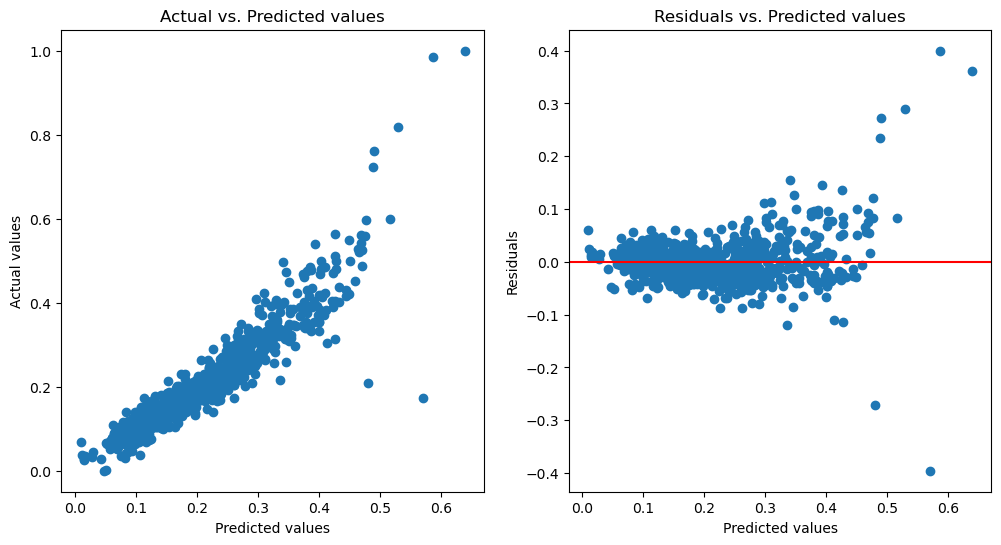

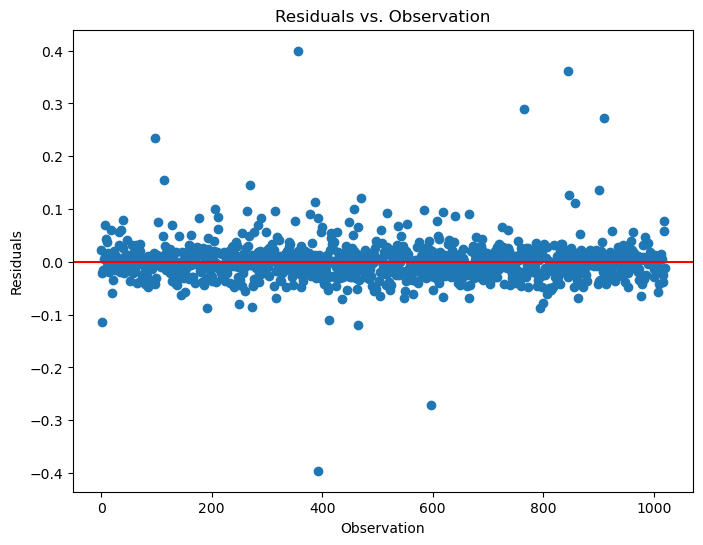

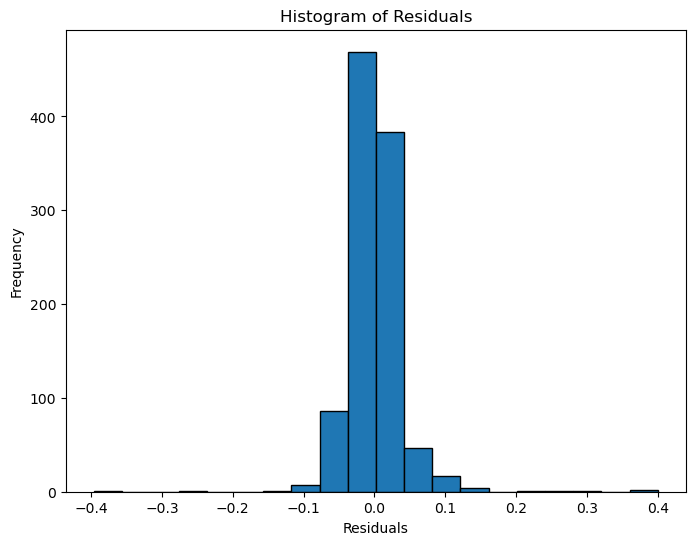

In [169]:
# Validate assumptions of linear regression
def validate_assumptions(y_train, y_pred, residuals):
    # Linear relationship
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, y_train)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title("Actual vs. Predicted values")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted values")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

    # Independence of errors
    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(residuals)), residuals)
    plt.xlabel("Observation")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Observation")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

    # Normality of errors
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=20, edgecolor='k')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Histogram of Residuals")
    plt.show()


# Assuming y_true, y_pred, and residuals are available
validate_assumptions(y_train, y_pred_train, y_train - y_pred_train)


In [170]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_train - y_pred_train))
print(rss)
mse = mean_squared_error(y_train, y_pred_train)
print(mse)
# Root Mean Squared Error
rmse = mse**0.5
print(rmse)

1.7044055849138462
0.001669349250650192
0.040857670646406066


In [171]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_test - y_pred_test))
print(rss)
mse = mean_squared_error(y_test, y_pred_test)
print(mse)
# Root Mean Squared Error
rmse = mse**0.5
print(rmse)

0.8349790245082729
0.0019063448048134083
0.04366170867949866


 # Answer to question 1:
 - Let's duble the value of lambda and check the changes in the best feature coefficients 

In [186]:
from sklearn.linear_model import Ridge
import pandas as pd

# Create and fit Ridge regression model with a double alpha
alpha = 20.0  # Choose your desired value of alpha
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

# Get the coefficients and feature names
coefficients = ridge.coef_
feature_names = X_train.columns

# Create a DataFrame to store feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['AbsCoefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='AbsCoefficient', ascending=False)

# Select the top five features
top_features = coefficients_df.head(15)

print("Top features with their coefficients:")
print(top_features)


Top features with their coefficients:
                 Feature  Coefficient  AbsCoefficient
1            OverallQual     0.065683        0.065683
74  Neighborhood_NoRidge     0.052820        0.052820
19             GrLivArea     0.050848        0.050848
18              2ndFlrSF     0.046252        0.046252
9           BsmtExposure    -0.045109        0.045109
27          TotRmsAbvGrd     0.040650        0.040650
17              1stFlrSF     0.039102        0.039102
29            Fireplaces     0.038416        0.038416
75  Neighborhood_NridgHt     0.038396        0.038396
26           KitchenQual    -0.038377        0.038377
33            GarageCars     0.037513        0.037513
5              ExterQual    -0.034453        0.034453
22              FullBath     0.031985        0.031985
34            GarageArea     0.031912        0.031912
7               BsmtQual    -0.030675        0.030675


In [187]:
# Count the number of rows where AbsCoefficient is non-zero
non_zero_count = (coefficients_df['AbsCoefficient'] != 0).sum()

print("Number of rows where AbsCoefficient is non-zero:", non_zero_count)

Number of rows where AbsCoefficient is non-zero: 183


In [188]:

# Predict prices of X_train
y_pred_train = ridge.predict(X_train)
r2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
print("R2 score on train set:", r2_train)

# Predict prices of X_test
y_pred_test = ridge.predict(X_test)
r2_test = sklearn.metrics.r2_score(y_test, y_pred_test)
print("R2 score on test set:", r2_test)

R2 score on train set: 0.8438317570075955
R2 score on test set: 0.833021045674356


## Inference - Model 4:
- The model accuracy as well as robustness has improved furher from model 3
    - R2 score on train set: 0.86
    - R2 score on test set: 0.85
- With optimal lambda value, the ridge regression hasn't reduced the number of dependant features. Still 183
- The error metrics (rss, mse and rms) for training data  seem to be within range
    - Residual Sum of Squares for Training set:  1.7
    - Mean Squared Error for training set:  0.001
    - Root Mean Squared Error for training set:  0.04
- The error metrics (rss, mse and rms) for test data  seem to be within range
    - Residual Sum of Squares for Test set:  0.83
    - Mean Squared Error for Test set:  0.002
    - Root Mean Squared Error for test set:  0.04
- There is a linear relationship between X and Y
    - X and Y should display a linear relationship
    - Error terms are distributed normally with mean equal to 0 (not X, Y)
    - Error terms are independent of each other
    - Error terms have constant variance (homoscedasticity)
### Top 5 predictor values as per the model:
1. OverallQual - Rating of overall material quality and finish of the house
2. GrLivArea - Above grade (ground) living area square feet
3. 2ndFlrSF - Second floor square feet
4. Neighborhood - Physical locations within Ames city limits
5. 1stFlrSF - First Floor square feet

# Question 1

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

### Lasso Regression: 
The optimal value of alpha is 0.001

When the value of alpha is doubled, we see following changes:
1. The R2 score reduced from 0.82 to 0.78. 
2. The number of predictor features has reduced from 24 to 22. 
3. Although the top  5 predictor variables did not change, their coefficients changed and hence the order of prefered features changed

**Top 5 predictor values with optimal value of alpha (i.e. 0.001):
1. GrLivArea - 0.239808        
2. OverallQual - 0.169949        
3. Neighborhood_NoRidge - 0.062858             
4. GarageCars - 0.058208        
5. KitchenQual - 0.049976        

**Top 5 predictor values whwn we double the value of alpha (i.e. 0.002):
1. OverallQual - 0.173505        
2. GrLivArea - 0.115436        
3. KitchenQual - (0.057848)
4. GarageCars - 0.057520        
5. Neighborhood_NoRidge - 0.047273     

### Ridge Regression: 
The optimal value of alpha is 10.0

When the value of alpha is doubled, we see following changes:
1. The R2 score reduced from 0.86 to 0.84. 
2. No of predictor variables remains the same i.e. 183
3. The coefficents of the top  5 predictor variables have changed. BsmtExposure is now 5th most where as 1stFlrSF is now not featuring in top 5

**Top 5 predictor values as per the optimal apha 10.0:
1. OverallQual - 0.082357                
2. GrLivArea - 0.065476
3. 2ndFlrSF - 0.062813        
4. Neighborhood - 0.060228
5. 1stFlrSF - 0.049093

**Top 5 predictor values as per the double apha 20.0:
1. OverallQual - 0.065683
2. Neighborhood_NoRidge - 0.052820
3. GrLivArea - 0.050848
4. 2ndFlrSF - 0.046252
5. BsmtExposure - (-0.045109)

# Question 2

You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?


## Lasso or Ridge - which model to select:

Based on the inferences captures, Ridge regression seems to be a better choice compared to Lasso Regression. Here's why:

1. **Higher R2 Score on Test Data**: Ridge regression has a higher R2 score on both the train and test sets compared to Lasso regression. A higher R2 score indicates that the model explains more variance in the target variable and performs better in generalization to unseen data.

2. **Better Error Metrics on Test Data**: Ridge regression has lower error metrics (RSS, MSE, RMSE) on the test data compared to Lasso regression. Lower error metrics indicate that the model's predictions are closer to the actual values, demonstrating better performance.

3. **Retained Features**: While Lasso regression reduced the number of dependent features from 185 to 24, Ridge regression retained all 183 features. In some cases, reducing the number of features can lead to oversimplification and loss of important information. Therefore, retaining more features in Ridge regression may provide a more comprehensive representation of the data.

4. **Similar Assumptions**: Both models satisfy the assumptions of linear regression, such as a linear relationship between predictors and the target variable, normal distribution of error terms with a mean of 0, independence of error terms, and constant variance of error terms.

Considering these factors, Ridge regression appears to be a better choice as it provides higher predictive accuracy, retains more features, and exhibits similar adherence to regression assumptions.

# Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

## Answer:

The top 5 predictor variables in lasso regression are GrLivArea, OverallQual, Neighborhood, GarageCars & KitchenQual. After dropping these variables from the base X_train and X_test data and build the model again. 

**Top 5 predictor feature as per new model are:
1. 1stFlrSF - 1stFlrSF: First Floor square feet
2. 2ndFlrSF - Second floor square feet
3. ExterQual - Evaluates the quality of the material on the exterior
4. GarageArea - Size of garage in square feet
5. Fireplaces - Number of fireplaces

- The model accuracy as well as robustness has reduced from model 3. However the test accuracy is at par with training set. 
    - R-squared on the training set: 0.768
    - R-squared on the test set: 0.769

In [197]:
X_test_2.head()

,LotFrontage,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Utilities_NoSeWa,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,0.133562,0.625,0.717391,0.350000,0.666667,0.666667,0.75,0.6,0.75,0.333333,0.109142,1.0,0.0,0.106164,0.141408,0.50,0.113889,0.000000,0.000000,0.0,0.333333,0.0,0.375,0.0,0.181818,0.0,0.000000,0.0,0.672727,1.000000,0.372355,0.6,0.6,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
57,0.232877,0.500,0.956522,0.900000,0.333333,0.666667,0.50,0.6,0.75,1.000000,0.000000,1.0,0.0,0.368151,0.140753,0.00,0.112963,0.416465,0.000000,0.0,0.666667,0.5,0.375,0.0,0.363636,0.0,0.000000,0.0,0.945455,0.666667,0.398449,0.6,0.6,0.000000,0.133843,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
780,0.143836,0.500,0.891304,0.766667,0.666667,0.666667,0.50,0.4,0.75,1.000000,0.000000,1.0,0.0,0.529538,0.202455,0.25,0.203935,0.000000,0.000000,0.0,0.666667,0.0,0.375,0.0,0.272727,0.0,0.333333,0.6,0.863636,0.333333,0.283498,0.6,0.6,0.256709,0.040153,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
382,0.198630,0.500,0.971014,0.933333,0.333333,0.666667,0.50,0.6,0.25,1.000000,0.

In [195]:
X_train_2 = X_train
X_train_2.drop(columns=['GrLivArea', 'OverallQual', 'Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker','GarageCars', 'KitchenQual'], inplace=True)

X_test_2 = X_test
X_test_2.drop(columns=['GrLivArea', 'OverallQual', 'Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker','GarageCars', 'KitchenQual'], inplace=True)

### Finding optimal value of lambda
Let's use GridSearchCV method to find the optimal value of lambda

In [198]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Define a range of alpha values to try
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

# Create a Lasso regression model
lasso = Lasso()

# Define the grid of hyperparameters to search
param_grid = {'alpha': alphas}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_2, y_train)

# Get the best alpha value found during cross-validation
best_alpha = grid_search.best_params_['alpha']

# Create and fit a Lasso regression model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_2, y_train)
print("Best Alpha using lasso is: ", best_alpha)

# Evaluate the model on the training set
y_train_pred_2 = lasso_best.predict(X_train_2)
r2_train_2 = r2_score(y_train, y_train_pred_2)
print("R-squared on the training set:", r2_train_2)

# Evaluate the model on the test set
y_test_pred_2 = lasso_best.predict(X_test_2)
r2_test_2 = r2_score(y_test, y_test_pred_2)
print("R-squared on the test set:", r2_test_2)


Best Alpha using lasso is:  0.001
R-squared on the training set: 0.7681099685095084
R-squared on the test set: 0.7695784877008525


### Optimal value of lambda with Lasso regression is 0.001

 - Let's find the best feature coefficients 

In [199]:
# Create and fit Lasso regression model
lasso = Lasso(alpha=0.001)  # You can adjust the regularization parameter alpha as needed
lasso.fit(X_train_2, y_train)
    
# Create RFE with Lasso model
rfe = RFE(lasso, n_features_to_select=157)
rfe.fit(X_train_2, y_train)
    
# Predict prices of X_train
y_pred_train_2 = rfe.predict(X_train_2)
r2_train_2 = sklearn.metrics.r2_score(y_train, y_pred_train_2)
print("R2 Score on Train Data:", r2_train_2)

R2 Score on Train Data: 0.7681099685095084


In [200]:
# Get the coefficients and feature names
coefficients = lasso.coef_
feature_names = X_train_2.columns

# Create a DataFrame to store feature names and coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['AbsCoefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='AbsCoefficient', ascending=False)

# Select the top features
top_features = coefficients_df.head(15)

print("Top predictor features with their coefficients:")
print(top_features)


Top predictor features with their coefficients:
              Feature  Coefficient  AbsCoefficient
16           1stFlrSF     0.187028        0.187028
17           2ndFlrSF     0.124349        0.124349
4           ExterQual    -0.119490        0.119490
30         GarageArea     0.101113        0.101113
26         Fireplaces     0.068715        0.068715
8        BsmtExposure    -0.055475        0.055475
24       TotRmsAbvGrd     0.037194        0.037194
3        YearRemodAdd     0.021879        0.021879
35      MSSubClass_20     0.019434        0.019434
29       GarageFinish    -0.017102        0.017102
9        BsmtFinType1    -0.016390        0.016390
122  Foundation_PConc     0.014940        0.014940
6            BsmtQual    -0.013117        0.013117
149      SaleType_New     0.011029        0.011029
57    Condition1_Norm     0.010232        0.010232


In [202]:
# Count the number of rows where AbsCoefficient is non-zero
non_zero_count = (coefficients_df['AbsCoefficient'] != 0).sum()

print("Number of rows where AbsCoefficient is non-zero:", non_zero_count)

Number of rows where AbsCoefficient is non-zero: 24
